Notes:

Data: http://data.healthybrainnetwork.org/ (LORIS, no new release in COINS)

Diagnosis is contained in the "Diagnosis_ClinicianConsensus" column (not in "ConsensusDx")

All NIH5 and NIH7 columns are empty

Diagnoses to predict:

- Specific Learning Disorder with Impairment in Reading
- Specific Learning Disorder with Impairment in Mathematics
- Intellectual Disability-Mild 
- Borderline Intellectual Functioning
- Specific Learning Disorder with Impairment in Written Expression
- Extra: ADHD-Inattentive Type (very common non-learning)
- Extra: Disruptive Mood Dysregulation Disorder (non-common non-learning)

In [39]:
import pandas as pd
import numpy as np
from collections import Counter
from re import M
import os

data_output_dir = "data/output/"
if not os.path.exists(data_output_dir):
    os.mkdir(data_output_dir)

data_intermediate_dir = "data/intermediate/"
if not os.path.exists(data_intermediate_dir):
    os.mkdir(data_intermediate_dir)
    
pd.set_option("display.max_columns", None)

## Read and prepare data

In [40]:
# LORIS saved query (all data)
full = pd.read_csv("data/LORIS-release-10.csv", dtype=object)

In [41]:
# Replace NaN (currently ".") values with np.nan
full = full.replace(".", np.nan)

In [42]:
# Drop first row (doesn't have ID)
full = full.iloc[1: , :]

In [43]:
# Examine LORIS columns
[print(x) for x in full.columns] 

Identifiers
ACE,ACE_01
ACE,ACE_02
ACE,ACE_03
ACE,ACE_04
ACE,ACE_05
ACE,ACE_06
ACE,ACE_07
ACE,ACE_08
ACE,ACE_09
ACE,ACE_10
ACE,ACE_Score
ACE,Administration
ACE,Comment_ID
ACE,Data_entry
ACE,Days_Baseline
ACE,EID
ACE,PSCID
ACE,START_DATE
ACE,Season
ACE,Site
ACE,Study
ACE,Visit_label
ACE,Year
ACE,﻿EID
APQ_P,APQ_P_01
APQ_P,APQ_P_02
APQ_P,APQ_P_03
APQ_P,APQ_P_04
APQ_P,APQ_P_05
APQ_P,APQ_P_06
APQ_P,APQ_P_07
APQ_P,APQ_P_08
APQ_P,APQ_P_09
APQ_P,APQ_P_10
APQ_P,APQ_P_11
APQ_P,APQ_P_12
APQ_P,APQ_P_13
APQ_P,APQ_P_14
APQ_P,APQ_P_15
APQ_P,APQ_P_16
APQ_P,APQ_P_17
APQ_P,APQ_P_18
APQ_P,APQ_P_19
APQ_P,APQ_P_20
APQ_P,APQ_P_21
APQ_P,APQ_P_22
APQ_P,APQ_P_23
APQ_P,APQ_P_24
APQ_P,APQ_P_25
APQ_P,APQ_P_26
APQ_P,APQ_P_27
APQ_P,APQ_P_28
APQ_P,APQ_P_29
APQ_P,APQ_P_30
APQ_P,APQ_P_31
APQ_P,APQ_P_32
APQ_P,APQ_P_33
APQ_P,APQ_P_34
APQ_P,APQ_P_35
APQ_P,APQ_P_36
APQ_P,APQ_P_37
APQ_P,APQ_P_38
APQ_P,APQ_P_39
APQ_P,APQ_P_40
APQ_P,APQ_P_41
APQ_P,APQ_P_42
APQ_P,APQ_P_CP
APQ_P,APQ_P_ID
APQ_P,APQ_P_INV
APQ_P,APQ_P_OPD
APQ_P,AP

DailyMeds,med_time_01
DailyMeds,med_time_02
DailyMeds,med_time_03
DailyMeds,med_type_01
DailyMeds,med_type_02
DailyMeds,med_type_03
DailyMeds,medications
DailyMeds,nic_01
DailyMeds,nic_02
DailyMeds,nic_amt_01
DailyMeds,nic_amt_02
DailyMeds,nic_time_01
DailyMeds,nic_time_02
DailyMeds,nicotine
DailyMeds,﻿EID
Diagnosis_ClinicianConsensus,Administration
Diagnosis_ClinicianConsensus,Comment_ID
Diagnosis_ClinicianConsensus,DX_01
Diagnosis_ClinicianConsensus,DX_01_ByHx
Diagnosis_ClinicianConsensus,DX_01_Cat
Diagnosis_ClinicianConsensus,DX_01_Code
Diagnosis_ClinicianConsensus,DX_01_Confirmed
Diagnosis_ClinicianConsensus,DX_01_New
Diagnosis_ClinicianConsensus,DX_01_PRem
Diagnosis_ClinicianConsensus,DX_01_Past_Doc
Diagnosis_ClinicianConsensus,DX_01_Presum
Diagnosis_ClinicianConsensus,DX_01_RC
Diagnosis_ClinicianConsensus,DX_01_Rem
Diagnosis_ClinicianConsensus,DX_01_RuleOut
Diagnosis_ClinicianConsensus,DX_01_Spec
Diagnosis_ClinicianConsensus,DX_01_Sub
Diagnosis_ClinicianConsensus,DX_01_Time
Diagn

NIDA,Year
NIDA,﻿EID
NIH5,Administration
NIH5,Comment_ID
NIH5,Data_entry
NIH5,Days_Baseline
NIH5,EID
NIH5,NIH5_Card
NIH5,NIH5_Card_P
NIH5,NIH5_Flanker
NIH5,NIH5_Flanker_P
NIH5,NIH5_List
NIH5,NIH5_List_P
NIH5,NIH5_Patten_P
NIH5,NIH5_Pattern
NIH5,NIH5_Picture
NIH5,NIH5_Picture_P
NIH5,PSCID
NIH5,START_DATE
NIH5,Season
NIH5,Site
NIH5,Study
NIH5,Visit_label
NIH5,Year
NIH7,Administration
NIH7,Comment_ID
NIH7,Data_entry
NIH7,Days_Baseline
NIH7,EID
NIH7,NIH7_Card
NIH7,NIH7_Card_P
NIH7,NIH7_Cog
NIH7,NIH7_Cog_P
NIH7,NIH7_Complete
NIH7,NIH7_Flanker
NIH7,NIH7_Flanker_P
NIH7,NIH7_Incomplete_Reason
NIH7,NIH7_List
NIH7,NIH7_List_P
NIH7,NIH7_Pattern
NIH7,NIH7_Pattern_P
NIH7,NIH7_Picture
NIH7,NIH7_Picture_P
NIH7,PSCID
NIH7,START_DATE
NIH7,Season
NIH7,Site
NIH7,Study
NIH7,Visit_label
NIH7,Year
NLES_P,Administration
NLES_P,Comment_ID
NLES_P,Data_entry
NLES_P,Days_Baseline
NLES_P,EID
NLES_P,NLES_P_01a
NLES_P,NLES_P_01b
NLES_P,NLES_P_01c
NLES_P,NLES_P_02a
NLES_P,NLES_P_02b
NLES_P,NLES_P_02c
NLES_P,NLES_P_03

PreInt_FamHx_RDC,fcodxm_1
PreInt_FamHx_RDC,fcodxm_2
PreInt_FamHx_RDC,fcodxm_3
PreInt_FamHx_RDC,fcourse
PreInt_FamHx_RDC,fdiabet
PreInt_FamHx_RDC,fdmonset
PreInt_FamHx_RDC,fdx
PreInt_FamHx_RDC,fdxpsych
PreInt_FamHx_RDC,fdxsev
PreInt_FamHx_RDC,fepidur
PreInt_FamHx_RDC,fepilep
PreInt_FamHx_RDC,fepino
PreInt_FamHx_RDC,ff_range
PreInt_FamHx_RDC,ffage
PreInt_FamHx_RDC,ffalive
PreInt_FamHx_RDC,ffdk
PreInt_FamHx_RDC,fff_range
PreInt_FamHx_RDC,fffage
PreInt_FamHx_RDC,fffalive
PreInt_FamHx_RDC,fffdk
PreInt_FamHx_RDC,ffhxanx
PreInt_FamHx_RDC,ffhxautism
PreInt_FamHx_RDC,ffhxbp
PreInt_FamHx_RDC,ffhxdep
PreInt_FamHx_RDC,ffhxdrg
PreInt_FamHx_RDC,ffhxfirstdp
PreInt_FamHx_RDC,ffhxfirstno
PreInt_FamHx_RDC,ffhxfirstpb
PreInt_FamHx_RDC,ffhxfirstsc
PreInt_FamHx_RDC,ffhxoh
PreInt_FamHx_RDC,ffhxsch
PreInt_FamHx_RDC,ffhxsuicide
PreInt_FamHx_RDC,ffm_range
PreInt_FamHx_RDC,ffmage
PreInt_FamHx_RDC,ffmalive
PreInt_FamHx_RDC,ffmfdk
PreInt_FamHx_RDC,fforhx
PreInt_FamHx_RDC,fgastroint
PreInt_FamHx_RDC,fheart
PreInt_

TRF,TRF_42
TRF,TRF_43
TRF,TRF_44
TRF,TRF_45
TRF,TRF_46
TRF,TRF_47
TRF,TRF_48
TRF,TRF_49
TRF,TRF_50
TRF,TRF_51
TRF,TRF_52
TRF,TRF_53
TRF,TRF_54
TRF,TRF_55
TRF,TRF_56a
TRF,TRF_56b
TRF,TRF_56c
TRF,TRF_56d
TRF,TRF_57
TRF,TRF_58
TRF,TRF_59
TRF,TRF_60
TRF,TRF_61
TRF,TRF_62
TRF,TRF_63
TRF,TRF_64
TRF,TRF_65
TRF,TRF_66
TRF,TRF_67
TRF,TRF_68
TRF,TRF_69
TRF,TRF_70
TRF,TRF_71
TRF,TRF_72
TRF,TRF_73
TRF,TRF_74
TRF,TRF_75
TRF,TRF_76
TRF,TRF_77
TRF,TRF_78
TRF,TRF_79
TRF,TRF_80
TRF,TRF_81
TRF,TRF_82
TRF,TRF_83
TRF,TRF_84
TRF,TRF_85
TRF,TRF_86
TRF,TRF_87
TRF,TRF_88
TRF,TRF_89
TRF,TRF_90
TRF,TRF_91
TRF,TRF_92
TRF,TRF_93
TRF,TRF_94
TRF,TRF_95
TRF,TRF_96
TRF,TRF_97
TRF,TRF_98
TRF,TRF_99
TRF,TRF_AB
TRF,TRF_AB_T
TRF,TRF_AD
TRF,TRF_AD_T
TRF,TRF_AP
TRF,TRF_AP_T
TRF,TRF_DSM_ADHD
TRF,TRF_DSM_ADHD_T
TRF,TRF_DSM_AN
TRF,TRF_DSM_AN_T
TRF,TRF_DSM_CP
TRF,TRF_DSM_CP_T
TRF,TRF_DSM_DP
TRF,TRF_DSM_DP_T
TRF,TRF_DSM_OD
TRF,TRF_DSM_OD_T
TRF,TRF_DSM_SP
TRF,TRF_DSM_SP_T
TRF,TRF_Ext
TRF,TRF_Ext_T
TRF,TRF_Int
TRF,TRF_Int_T
TRF,T

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [44]:
# Drop empty columns
print(len(full.columns))
cols_before_remove_empty = full.columns
full = full.dropna(how='all', axis=1)
cols_after_remove_empty = full.columns
print(len(full.columns))
display(sorted(list(set(cols_before_remove_empty) - set(cols_after_remove_empty))))

7284
6149


['ACE,Comment_ID',
 'ACE,PSCID',
 'ACE,Visit_label',
 'ACE,\ufeffEID',
 'APPLEQUAN""',
 'APPLSCQUAN""',
 'APQ_P,Comment_ID',
 'APQ_P,PSCID',
 'APQ_P,Visit_label',
 'APQ_P,\ufeffEID',
 'APQ_SR,Comment_ID',
 'APQ_SR,PSCID',
 'APQ_SR,Visit_label',
 'APQ_SR,\ufeffEID',
 'ARI_P,Comment_ID',
 'ARI_P,PSCID',
 'ARI_P,Visit_label',
 'ARI_P,\ufeffEID',
 'ARI_S,Comment_ID',
 'ARI_S,PSCID',
 'ARI_S,Visit_label',
 'ARI_S,\ufeffEID',
 'ASR,Comment_ID',
 'ASR,PSCID',
 'ASR,Visit_label',
 'ASR,\ufeffEID',
 'ASSQ,Comment_ID',
 'ASSQ,PSCID',
 'ASSQ,Visit_label',
 'ASSQ,\ufeffEID',
 'Acc""',
 'Act_Sev_10""',
 'Age""',
 'Area_Head""',
 'Attentive""',
 'Audit,Comment_ID',
 'Audit,PSCID',
 'Audit,Visit_label',
 'Audit,\ufeffEID',
 'BIA,"Activity_Level",BIA',
 'BIA,"BMC",BIA',
 'BIA,"BMR",BIA',
 'BIA,"Days_Baseline",BIA',
 'BIA,"EID",BIA',
 'BIA,"FFMI",BIA',
 'BIA,"Fat",BIA',
 'BIA,"Height",BIA',
 'BIA,"LDM",BIA',
 'BIA,"SMM",BIA',
 'BIA,"Season",BIA',
 'BIA,"Study",BIA',
 'BIA,"TBW",BIA',
 'BIA,"Year",BIA',

In [45]:
# Remove uninteresting columns
columns_to_drop = []

column_suffixes_to_drop = ["Administration", "Data_entry", "Days_Baseline", "START_DATE", "Season", "Site", "Study", "Year", "Commercial_Use", "Release_Number"]
for suffix in column_suffixes_to_drop:
    cols_w_suffix = [x for x in full.columns if suffix in x]
    columns_to_drop.extend(cols_w_suffix)

present_columns_to_drop = full.filter(columns_to_drop)
print(len(full.columns))
full = full.drop(present_columns_to_drop, axis = 1)
print(len(full.columns))

6149
5318


In [46]:
# Check which columns have weird column names with quotes, like: "BIA,"Year",BIA"
cols_w_broken_quotes = [x for x in full.columns if ('"') in x] 
cols_w_broken_quotes

[]

In [47]:
# Remove questionnaires with broken quotes
full = full.drop(cols_w_broken_quotes, axis=1)

In [48]:
[print(x) for x in full.columns] 

Identifiers
ACE,ACE_01
ACE,ACE_02
ACE,ACE_03
ACE,ACE_04
ACE,ACE_05
ACE,ACE_06
ACE,ACE_07
ACE,ACE_08
ACE,ACE_09
ACE,ACE_10
ACE,ACE_Score
ACE,EID
APQ_P,APQ_P_01
APQ_P,APQ_P_02
APQ_P,APQ_P_03
APQ_P,APQ_P_04
APQ_P,APQ_P_05
APQ_P,APQ_P_06
APQ_P,APQ_P_07
APQ_P,APQ_P_08
APQ_P,APQ_P_09
APQ_P,APQ_P_10
APQ_P,APQ_P_11
APQ_P,APQ_P_12
APQ_P,APQ_P_13
APQ_P,APQ_P_14
APQ_P,APQ_P_15
APQ_P,APQ_P_16
APQ_P,APQ_P_17
APQ_P,APQ_P_18
APQ_P,APQ_P_19
APQ_P,APQ_P_20
APQ_P,APQ_P_21
APQ_P,APQ_P_22
APQ_P,APQ_P_23
APQ_P,APQ_P_24
APQ_P,APQ_P_25
APQ_P,APQ_P_26
APQ_P,APQ_P_27
APQ_P,APQ_P_28
APQ_P,APQ_P_29
APQ_P,APQ_P_30
APQ_P,APQ_P_31
APQ_P,APQ_P_32
APQ_P,APQ_P_33
APQ_P,APQ_P_34
APQ_P,APQ_P_35
APQ_P,APQ_P_36
APQ_P,APQ_P_37
APQ_P,APQ_P_38
APQ_P,APQ_P_39
APQ_P,APQ_P_40
APQ_P,APQ_P_41
APQ_P,APQ_P_42
APQ_P,APQ_P_CP
APQ_P,APQ_P_ID
APQ_P,APQ_P_INV
APQ_P,APQ_P_OPD
APQ_P,APQ_P_PM
APQ_P,APQ_P_PP
APQ_P,APQ_P_Total
APQ_P,EID
APQ_SR,APQ_SR_01
APQ_SR,APQ_SR_01A
APQ_SR,APQ_SR_02
APQ_SR,APQ_SR_03
APQ_SR,APQ_SR_04
APQ_SR,APQ_SR_04A
AP

MFQ_P,MFQ_P_07
MFQ_P,MFQ_P_08
MFQ_P,MFQ_P_09
MFQ_P,MFQ_P_10
MFQ_P,MFQ_P_11
MFQ_P,MFQ_P_12
MFQ_P,MFQ_P_13
MFQ_P,MFQ_P_14
MFQ_P,MFQ_P_15
MFQ_P,MFQ_P_16
MFQ_P,MFQ_P_17
MFQ_P,MFQ_P_18
MFQ_P,MFQ_P_19
MFQ_P,MFQ_P_20
MFQ_P,MFQ_P_21
MFQ_P,MFQ_P_22
MFQ_P,MFQ_P_23
MFQ_P,MFQ_P_24
MFQ_P,MFQ_P_25
MFQ_P,MFQ_P_26
MFQ_P,MFQ_P_27
MFQ_P,MFQ_P_28
MFQ_P,MFQ_P_29
MFQ_P,MFQ_P_30
MFQ_P,MFQ_P_31
MFQ_P,MFQ_P_32
MFQ_P,MFQ_P_33
MFQ_P,MFQ_P_34
MFQ_P,MFQ_P_Total
MFQ_SR,EID
MFQ_SR,MFQ_SR_01
MFQ_SR,MFQ_SR_02
MFQ_SR,MFQ_SR_03
MFQ_SR,MFQ_SR_04
MFQ_SR,MFQ_SR_05
MFQ_SR,MFQ_SR_06
MFQ_SR,MFQ_SR_07
MFQ_SR,MFQ_SR_08
MFQ_SR,MFQ_SR_09
MFQ_SR,MFQ_SR_10
MFQ_SR,MFQ_SR_11
MFQ_SR,MFQ_SR_12
MFQ_SR,MFQ_SR_13
MFQ_SR,MFQ_SR_14
MFQ_SR,MFQ_SR_15
MFQ_SR,MFQ_SR_16
MFQ_SR,MFQ_SR_17
MFQ_SR,MFQ_SR_18
MFQ_SR,MFQ_SR_19
MFQ_SR,MFQ_SR_20
MFQ_SR,MFQ_SR_21
MFQ_SR,MFQ_SR_22
MFQ_SR,MFQ_SR_23
MFQ_SR,MFQ_SR_24
MFQ_SR,MFQ_SR_25
MFQ_SR,MFQ_SR_26
MFQ_SR,MFQ_SR_27
MFQ_SR,MFQ_SR_28
MFQ_SR,MFQ_SR_29
MFQ_SR,MFQ_SR_30
MFQ_SR,MFQ_SR_31
MFQ_SR,MFQ_SR_32
MFQ_SR,

PreInt_FamHx_RDC,osib3_relation
PreInt_FamHx_RDC,osib3age
PreInt_FamHx_RDC,osib3sex
PreInt_FamHx_RDC,osib4_relation
PreInt_FamHx_RDC,osib4age_2
PreInt_FamHx_RDC,osib4sex
PreInt_FamHx_RDC,osib5_relation
PreInt_FamHx_RDC,osib5age
PreInt_FamHx_RDC,osib5sex
PreInt_FamHx_RDC,sib1arthrit
PreInt_FamHx_RDC,sib1asthma
PreInt_FamHx_RDC,sib1attempts
PreInt_FamHx_RDC,sib1attleth
PreInt_FamHx_RDC,sib1attsev
PreInt_FamHx_RDC,sib1cancer
PreInt_FamHx_RDC,sib1codxm_1
PreInt_FamHx_RDC,sib1codxm_2
PreInt_FamHx_RDC,sib1codxm_3
PreInt_FamHx_RDC,sib1course
PreInt_FamHx_RDC,sib1diabet
PreInt_FamHx_RDC,sib1dmonset
PreInt_FamHx_RDC,sib1dx
PreInt_FamHx_RDC,sib1dxpsych
PreInt_FamHx_RDC,sib1dxse
PreInt_FamHx_RDC,sib1epidur
PreInt_FamHx_RDC,sib1epilep
PreInt_FamHx_RDC,sib1epino
PreInt_FamHx_RDC,sib1forhx
PreInt_FamHx_RDC,sib1gastroint
PreInt_FamHx_RDC,sib1heart
PreInt_FamHx_RDC,sib1hospit
PreInt_FamHx_RDC,sib1hospitdur
PreInt_FamHx_RDC,sib1hypert
PreInt_FamHx_RDC,sib1info
PreInt_FamHx_RDC,sib1kidney
PreInt_FamHx_R

WIAT,WIAT_Num_Stnd
WIAT,WIAT_Pseudo_P
WIAT,WIAT_Pseudo_Raw
WIAT,WIAT_Pseudo_Stnd
WIAT,WIAT_RC_P
WIAT,WIAT_RC_Raw
WIAT,WIAT_RC_Stnd
WIAT,WIAT_Spell_P
WIAT,WIAT_Spell_Raw
WIAT,WIAT_Spell_Stnd
WIAT,WIAT_Valid
WIAT,WIAT_Word_P
WIAT,WIAT_Word_Raw
WIAT,WIAT_Word_Stnd
WISC,EID
WISC,WISC_BD_Raw
WISC,WISC_BD_Scaled
WISC,WISC_Coding_Raw
WISC,WISC_Coding_Scaled
WISC,WISC_DS_Raw
WISC,WISC_DS_Scaled
WISC,WISC_FRI
WISC,WISC_FRI_Percentile
WISC,WISC_FRI_Sum
WISC,WISC_FSIQ
WISC,WISC_FSIQ_Percentile
WISC,WISC_FSIQ_Sum
WISC,WISC_FW_Raw
WISC,WISC_FW_Scaled
WISC,WISC_MR_Raw
WISC,WISC_MR_Scaled
WISC,WISC_PSI
WISC,WISC_PSI_Percentile
WISC,WISC_PSI_Sum
WISC,WISC_PS_Raw
WISC,WISC_PS_Scaled
WISC,WISC_SS_Raw
WISC,WISC_SS_Scaled
WISC,WISC_Similarities_Raw
WISC,WISC_Similarities_Scaled
WISC,WISC_VCI
WISC,WISC_VCI_Percentile
WISC,WISC_VCI_Sum
WISC,WISC_VP_Raw
WISC,WISC_VP_Scaled
WISC,WISC_VSI
WISC,WISC_VSI_Percentile
WISC,WISC_VSI_Sum
WISC,WISC_Vocab_Raw
WISC,WISC_Vocab_Scaled
WISC,WISC_WMI
WISC,WISC_WMI_Percentil

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [49]:
# Check if there is a EID column
EID_cols = [x for x in full.columns if ",EID" in x]
EID_cols

['ACE,EID',
 'APQ_P,EID',
 'APQ_SR,EID',
 'ARI_P,EID',
 'ARI_S,EID',
 'ASR,EID',
 'ASSQ,EID',
 'Audit,EID',
 'BIA,EID',
 'Barratt,EID',
 'Basic_Demos,EID',
 'C3SR,EID',
 'CAARS,EID',
 'CBCL,EID',
 'CBCL_Pre,EID',
 'CCSC,EID',
 'CDI_P,EID',
 'CDI_SR,EID',
 'CELF,EID',
 'CELF5_Meta,EID',
 'CELF_Full_5to8,EID',
 'CELF_Full_9to21,EID',
 'CELF_Meta,EID',
 'CGAS,EID',
 'CIS_P,EID',
 'CIS_SR,EID',
 'CPIC,EID',
 'CTOPP,EID',
 'ColorVision,EID',
 'ConsensusDx,EID',
 'DTS,EID',
 'DailyMeds,EID',
 'Diagnosis_ClinicianConsensus,EID',
 'DigitSpan,EID',
 'DrugScreen,EID',
 'EEG_Track,EID',
 'EHQ,EID',
 'ESPAD,EID',
 'ESWAN,EID',
 'EVT,EID',
 'FFQ,EID',
 'FGC,EID',
 'FSQ,EID',
 'FTND,EID',
 'FTQA,EID',
 'GFTA,EID',
 'IAT,EID',
 'ICU_P,EID',
 'KBIT,EID',
 'MFQ_P,EID',
 'MFQ_SR,EID',
 'MRI_Track,EID',
 'NIDA,EID',
 'NLES_P,EID',
 'NLES_SR,EID',
 'PAQ_A,EID',
 'PAQ_C,EID',
 'PBQ,EID',
 'PCIAT,EID',
 'PPS,EID',
 'PPVT,EID',
 'PSI,EID',
 'Pegboard,EID',
 'PhenX_Neighborhood,EID',
 'PhenX_SchoolRisk,EID',


In [50]:
# Check if EID is equal among the questionnaires in one row
full_for_EID_check = full[EID_cols]

## Fill missing EIDs with EIDs from other questionnaires 
full_for_EID_check = full_for_EID_check.ffill(axis=1).bfill(axis=1)

## Check if the EID of all columns are equal to EID of the first column
print(full_for_EID_check.eq(full_for_EID_check.iloc[:, 0], axis=0).all(1).value_counts())

# Remove 16 lines with different EID within one row
print(len(full))
full = full[full_for_EID_check.eq(full_for_EID_check.iloc[:, 0], axis=0).all(1)]
print(len(full))

# ==> EID of each questionnaire are the same in a row, can use the first non-empty one as an ID

True     7227
False      16
dtype: int64
7243
7227


In [51]:
# Fill ID field with the first non-null questionnaire-specific EID
full["ID"] = full_for_EID_check.iloc[:, 0]

print(len(full.index))

# Check which questionnaires are present in the rows with unserscores (NDARZZ007YMP_1, NDARAA075AMK_Visit_1)
rows_with_underscore_in_id = full[full["ID"].str.contains("_")]
non_empty_columns_in_underscore = rows_with_underscore_in_id.columns[
    ~rows_with_underscore_in_id.isna().all()].tolist() 
non_empty_questionnaires_in_underscore = set([x.split(",")[0] for x in non_empty_columns_in_underscore])
non_empty_questionnaires_in_underscore

# Drop rows with underscores
non_empty_questionnaires_in_underscore.remove("Identifiers")
non_empty_questionnaires_in_underscore.remove("ID")
full_wo_underscore = full[~full["ID"].str.contains("_")]

# Drop questionnaires present in rows with underscores from data ({'DailyMeds', 'TRF', 'TRF_P', 'TRF_Pre'})
for questionnaire in non_empty_questionnaires_in_underscore:
    full_wo_underscore = full_wo_underscore.drop(full_wo_underscore.filter(regex=(questionnaire+",")), axis=1)
    
# Drop questionnaires present in rows with underscores from data from list of ID columns (will be used to check if an assessment is filled)
EID_cols = [x for x in EID_cols if 'TRF' not in x]
EID_cols = [x for x in EID_cols if 'DailyMeds' not in x]

print(len(full_wo_underscore.index))
print(len(full_wo_underscore["ID"].unique()))

7227
4146
4146


In [52]:
# Remove incomplete DX and missing DX

full_wo_underscore = full_wo_underscore[full_wo_underscore["Diagnosis_ClinicianConsensus,DX_01"] != "No Diagnosis Given: Incomplete Eval"]
full_wo_underscore = full_wo_underscore[full_wo_underscore["Diagnosis_ClinicianConsensus,EID"].notna()]
full_wo_underscore["ID"].nunique()

3613

In [53]:
# Get list of assessments in data
assessment_list = set([x.split(",")[0] for x in EID_cols])

# Get assessments most people filled
pd.set_option('display.max_rows', None)
assessment_answer_counts = full_wo_underscore[EID_cols].count().sort_values(ascending=False).to_frame()
assessment_answer_counts["Ratio"] = assessment_answer_counts[0]/full_wo_underscore["ID"].nunique()*100
display(assessment_answer_counts)

assessment_answer_counts.to_csv("data/output/assessment_filled_distrib.csv")

,0,Ratio
"Basic_Demos,EID",3613,100.000000
"Diagnosis_ClinicianConsensus,EID",3613,100.000000
"PreInt_EduHx,EID",3603,99.723222
"PreInt_DevHx,EID",3601,99.667866
"PreInt_TxHx,EID",3593,99.446443
"WIAT,EID",3592,99.418766
"Pegboard,EID",3568,98.754498
"SympChck,EID",3562,98.588431
"SCQ,EID",3561,98.560753
"Barratt,EID",3554,98.367008


In [54]:
# Get list of assessments sorted by popularity
EID_columns_by_popularity = assessment_answer_counts.index

# Only include relevant cognitive testing, Questionnaire Measures of Emotional and Cognitive Status, and Questionnaire Measures of Family Structure, Stress, and Trauma
relevant_EID_list = [x+",EID" for x in ["Basic_Demos", "WIAT", "SympChck", "SCQ", "Barratt", "ASSQ", "ARI_P", "SDQ", "SWAN", "SRS", "CBCL", "ICU_P", "APQ_P", "PCIAT", "DTS", "ESWAN", "MFQ_P", "APQ_SR", "WISC", "WHODAS_P", "CIS_P", "PSI", "RBS", "PhenX_Neighborhood", "WHODAS_SR", "CIS_SR", "SCARED_SR", "C3SR", "CCSC", "CPIC", "YSR", "PhenX_SchoolRisk", "CBCL_Pre", "SRS_Pre", "ASR"]]
EID_columns_by_popularity = [x for x in EID_columns_by_popularity if x in relevant_EID_list]

In [55]:
# Get number of people who took all top 1, top 2, top 3, etc. popular assessments (cumulative assessment distribution)
cumul_number_of_examples_list = []
for i in range(1, len(EID_columns_by_popularity)+1):
    columns = EID_columns_by_popularity[0:i] # top i assessments
    cumul_number_of_examples = full_wo_underscore[columns].notnull().all(axis=1).sum()
    cumul_number_of_examples_list.append([cumul_number_of_examples, [x.split(",")[0] for x in columns]])
cumul_number_of_examples_df = pd.DataFrame(cumul_number_of_examples_list)
cumul_number_of_examples_df.columns = ("Respondents", "Assessments")
cumul_number_of_examples_df.to_csv("data/output/assessment_filled_distrib_cumul.csv")

In [56]:
# List of most popular assessments until the first one with an age restriction
EID_columns_until_SCARED = [x for x in EID_columns_by_popularity[:EID_columns_by_popularity.index("SCARED_SR,EID")]]
EID_columns_until_SCARED

['Basic_Demos,EID',
 'WIAT,EID',
 'SympChck,EID',
 'SCQ,EID',
 'Barratt,EID',
 'ASSQ,EID',
 'ARI_P,EID',
 'SDQ,EID',
 'SWAN,EID',
 'SRS,EID',
 'CBCL,EID',
 'ICU_P,EID',
 'APQ_P,EID',
 'PCIAT,EID',
 'DTS,EID',
 'ESWAN,EID',
 'MFQ_P,EID',
 'APQ_SR,EID',
 'WISC,EID',
 'WHODAS_P,EID',
 'CIS_P,EID',
 'PSI,EID',
 'RBS,EID',
 'PhenX_Neighborhood,EID',
 'WHODAS_SR,EID',
 'CIS_SR,EID']

In [57]:
# Get only people who took the most popular assessments until the first one with an age restriction (SCARED_SR)
columns_until_SCARED = []
assessments_until_SCARED = [x.split(",")[0]+"," for x in EID_columns_until_SCARED]
for assessment in assessments_until_SCARED:
    columns = [column for column in full_wo_underscore.columns if column.startswith(assessment)]
    columns_until_SCARED.extend(columns)
    
diag_colunms = ["Diagnosis_ClinicianConsensus,DX_01", "Diagnosis_ClinicianConsensus,DX_02", "Diagnosis_ClinicianConsensus,DX_03", "Diagnosis_ClinicianConsensus,DX_04", "Diagnosis_ClinicianConsensus,DX_05", "Diagnosis_ClinicianConsensus,DX_06", "Diagnosis_ClinicianConsensus,DX_07", "Diagnosis_ClinicianConsensus,DX_08", "Diagnosis_ClinicianConsensus,DX_09", "Diagnosis_ClinicianConsensus,DX_10"]
data_up_to_SCARED = full_wo_underscore.loc[full_wo_underscore[EID_columns_until_SCARED].dropna(how="any").index][columns_until_SCARED+["ID"]+diag_colunms]

# Remove EID columns: not needed anymore
data_up_to_SCARED = data_up_to_SCARED.drop(EID_columns_until_SCARED, axis=1)

In [58]:
# Remove non-used output columns
print([x for x in data_up_to_SCARED.columns if "WIAT" in x])
WIAT_cols_to_keep = ["WIAT,WIAT_Word_Stnd", "WIAT,WIAT_Num_Stnd"]
WIAT_cols_to_drop = [x for x in data_up_to_SCARED.columns if "WIAT" in x and x not in WIAT_cols_to_keep] 
data_up_to_SCARED = data_up_to_SCARED.drop(WIAT_cols_to_drop, axis=1)
print([x for x in data_up_to_SCARED.columns if "WIAT" in x])

print([x for x in data_up_to_SCARED.columns if "WISC" in x])
WISC_cols_to_keep = ["WISC,WISC_Coding_Scaled", "WISC,WISC_SS_Scaled", "WISC,WISC_FSIQ"]
WISC_cols_to_drop = [x for x in data_up_to_SCARED.columns if "WISC" in x and x not in WISC_cols_to_keep] 
data_up_to_SCARED = data_up_to_SCARED.drop(WISC_cols_to_drop, axis=1)
print([x for x in data_up_to_SCARED.columns if "WISC" in x])

display(data_up_to_SCARED.iloc[:5,:])

['WIAT,WIAT_Complete', 'WIAT,WIAT_Incomplete_reason', 'WIAT,WIAT_Invalid_Reason', 'WIAT,WIAT_LCODC_P', 'WIAT,WIAT_LCODC_Raw', 'WIAT,WIAT_LCODC_Stnd', 'WIAT,WIAT_LCRV_P', 'WIAT,WIAT_LCRV_Raw', 'WIAT,WIAT_LCRV_Std', 'WIAT,WIAT_LC_P', 'WIAT,WIAT_LC_Stnd', 'WIAT,WIAT_MP_P', 'WIAT,WIAT_MP_Raw', 'WIAT,WIAT_MP_Stnd', 'WIAT,WIAT_Num_P', 'WIAT,WIAT_Num_Raw', 'WIAT,WIAT_Num_Stnd', 'WIAT,WIAT_Pseudo_P', 'WIAT,WIAT_Pseudo_Raw', 'WIAT,WIAT_Pseudo_Stnd', 'WIAT,WIAT_RC_P', 'WIAT,WIAT_RC_Raw', 'WIAT,WIAT_RC_Stnd', 'WIAT,WIAT_Spell_P', 'WIAT,WIAT_Spell_Raw', 'WIAT,WIAT_Spell_Stnd', 'WIAT,WIAT_Valid', 'WIAT,WIAT_Word_P', 'WIAT,WIAT_Word_Raw', 'WIAT,WIAT_Word_Stnd']
['WIAT,WIAT_Num_Stnd', 'WIAT,WIAT_Word_Stnd']
['WISC,WISC_BD_Raw', 'WISC,WISC_BD_Scaled', 'WISC,WISC_Coding_Raw', 'WISC,WISC_Coding_Scaled', 'WISC,WISC_DS_Raw', 'WISC,WISC_DS_Scaled', 'WISC,WISC_FRI', 'WISC,WISC_FRI_Percentile', 'WISC,WISC_FRI_Sum', 'WISC,WISC_FSIQ', 'WISC,WISC_FSIQ_Percentile', 'WISC,WISC_FSIQ_Sum', 'WISC,WISC_FW_Raw', 'WISC

,"Basic_Demos,Age","Basic_Demos,Sex","WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd","SympChck,CSC_01C","SympChck,CSC_01P","SympChck,CSC_02C","SympChck,CSC_02P","SympChck,CSC_03C","SympChck,CSC_03P","SympChck,CSC_04C","SympChck,CSC_04P","SympChck,CSC_05C","SympChck,CSC_05P","SympChck,CSC_06C","SympChck,CSC_06P","SympChck,CSC_07C","SympChck,CSC_07P","SympChck,CSC_08C","SympChck,CSC_08P","SympChck,CSC_09C","SympChck,CSC_09P","SympChck,CSC_10C","SympChck,CSC_10P","SympChck,CSC_11C","SympChck,CSC_11P","SympChck,CSC_12C","SympChck,CSC_12P","SympChck,CSC_13C","SympChck,CSC_13P","SympChck,CSC_14C","SympChck,CSC_14P","SympChck,CSC_15C","SympChck,CSC_15P","SympChck,CSC_16C","SympChck,CSC_16P","SympChck,CSC_17C","SympChck,CSC_17P","SympChck,CSC_18C","SympChck,CSC_18P","SympChck,CSC_19C","SympChck,CSC_19P","SympChck,CSC_20C","SympChck,CSC_20P","SympChck,CSC_21C","SympChck,CSC_21P","SympChck,CSC_22C","SympChck,CSC_22P","SympChck,CSC_23C","SympChck,CSC_23P","SympChck,CSC_24C","SympChck,CSC_24P","SympChck,CSC_25C","SympChck,CSC_25P","SympChck,CSC_26C","SympChck,CSC_26P","SympChck,CSC_27C","SympChck,CSC_27P","SympChck,CSC_28C","SympChck,CSC_28P","SympChck,CSC_29C","SympChck,CSC_29P","SympChck,CSC_30C","SympChck,CSC_30P","SympChck,CSC_31C","SympChck,CSC_31P","SympChck,CSC_32C","SympChck,CSC_32P","SympChck,CSC_33C","SympChck,CSC_33P","SympChck,CSC_34C","SympChck,CSC_34P","SympChck,CSC_35C","SympChck,CSC_35P","SympChck,CSC_36C","SympChck,CSC_36P","SympChck,CSC_37C","SympChck,CSC_37P","SympChck,CSC_38C","SympChck,CSC_38P","SympChck,CSC_39C","SympChck,CSC_39P","SympChck,CSC_40C","SympChck,CSC_40P","SympChck,CSC_41C","SympChck,CSC_41P","SympChck,CSC_42C","SympChck,CSC_42P","SympChck,CSC_43C","SympChck,CSC_43P","SympChck,CSC_44C","SympChck,CSC_44P","SympChck,CSC_45C","SympChck,CSC_45P","SympChck,CSC_46C","SympChck,CSC_46P","SympChck,CSC_47C","SympChck,CSC_47P","SympChck,CSC_48C","SympChck,CSC_48P","SympChck,CSC_49C","SympChck,CSC_49P","SympChck,CSC_50C","SympChck,CSC_50P","SympChck,CSC_51C","SympChck,CSC_51P","SympChck,CSC_52C","SympChck,CSC_52P","SympChck,CSC_53C","SympChck,CSC_53P","SympChck,CSC_54C","SympChck,CSC_54P","SympChck,CSC_55aC","SympChck,CSC_55aP","SympChck,CSC_55bC","SympChck,CSC_55bP","SympChck,CSC_55cC","SympChck,CSC_55cP","SympChck,CSC_55dC","SympChck,CSC_55dP","SympChck,CSC_55eC","SympChck,CSC_55eP","SympChck,CSC_55fC","SympChck,CSC_55fP","SympChck,CSC_55gC","SympChck,CSC_55gP","SympChck,CSC_55hC","SympChck,CSC_55hP","SympChck,CSC_55iC","SympChck,CSC_55iP","SCQ,SCQ_01","SCQ,SCQ_02","SCQ,SCQ_03","SCQ,SCQ_04","SCQ,SCQ_05","SCQ,SCQ_06","SCQ,SCQ_07","SCQ,SCQ_08","SCQ,SCQ_09","SCQ,SCQ_10","SCQ,SCQ_11","SCQ,SCQ_12","SCQ,SCQ_13","SCQ,SCQ_14","SCQ,SCQ_15","SCQ,SCQ_16","SCQ,SCQ_17","SCQ,SCQ_18","SCQ,SCQ_19","SCQ,SCQ_20","SCQ,SCQ_21","SCQ,SCQ_22","SCQ,SCQ_23","SCQ,SCQ_24","SCQ,SCQ_25","SCQ,SCQ_26","SCQ,SCQ_27","SCQ,SCQ_28","SCQ,SCQ_29","SCQ,SCQ_30","SCQ,SCQ_31","SCQ,SCQ_32","SCQ,SCQ_33","SCQ,SCQ_34","SCQ,SCQ_35","SCQ,SCQ_36","SCQ,SCQ_37","SCQ,SCQ_38","SCQ,SCQ_39","SCQ,SCQ_40","SCQ,SCQ_Total","Barratt,Barratt_P1_Edu","Barratt,Barratt_P1_Occ","Barratt,Barratt_P2_Edu","Barratt,Barratt_P2_Occ","Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ","Barratt,financialsupport","ASSQ,ASSQ_01","ASSQ,ASSQ_02","ASSQ,ASSQ_03","ASSQ,ASSQ_04","ASSQ,ASSQ_05","ASSQ,ASSQ_06","ASSQ,ASSQ_07","ASSQ,ASSQ_08","ASSQ,ASSQ_09","ASSQ,ASSQ_10","ASSQ,ASSQ_11","ASSQ,ASSQ_12","ASSQ,ASSQ_13","ASSQ,ASSQ_14","ASSQ,ASSQ_15","ASSQ,ASSQ_16","ASSQ,ASSQ_17","ASSQ,ASSQ_18","ASSQ,ASSQ_19","ASSQ,ASSQ_20","ASSQ,ASSQ_21","ASSQ,ASSQ_22","ASSQ,ASSQ_23","ASSQ,ASSQ_24","ASSQ,ASSQ_25","ASSQ,ASSQ_26","ASSQ,ASSQ_27","ASSQ,ASSQ_Total","ARI_P,ARI_P_01","ARI_P,ARI_P_02","ARI_P,ARI_P_03","ARI_P,ARI_P_04","ARI_P,ARI_P_05","ARI_P,ARI_P_06","ARI_P,ARI_P_07","ARI_P,ARI_P_Total_Score","SDQ,SDQ_01","SDQ,SDQ_02","SDQ,SDQ_03","SDQ,SDQ_04","SDQ,SDQ_05","SDQ,SDQ_06","SDQ,SDQ_07","SDQ,SDQ_08","SDQ,SDQ_09","SDQ,SDQ_10","SDQ,SDQ_11","SDQ,SDQ_12","SDQ,SDQ_13","SDQ,SDQ_14","SDQ,SDQ_15","S

In [59]:
# Aggregare demographics input columns
print(assessments_until_SCARED)

print([x for x in data_up_to_SCARED.columns if x.startswith("Barratt")])

## Remove per parent data from Barratt
data_up_to_SCARED = data_up_to_SCARED.drop(["Barratt,Barratt_P1_Edu", "Barratt,Barratt_P1_Occ", "Barratt,Barratt_P2_Edu", "Barratt,Barratt_P2_Occ"], axis=1)

['Basic_Demos,', 'WIAT,', 'SympChck,', 'SCQ,', 'Barratt,', 'ASSQ,', 'ARI_P,', 'SDQ,', 'SWAN,', 'SRS,', 'CBCL,', 'ICU_P,', 'APQ_P,', 'PCIAT,', 'DTS,', 'ESWAN,', 'MFQ_P,', 'APQ_SR,', 'WISC,', 'WHODAS_P,', 'CIS_P,', 'PSI,', 'RBS,', 'PhenX_Neighborhood,', 'WHODAS_SR,', 'CIS_SR,']
['Barratt,Barratt_P1_Edu', 'Barratt,Barratt_P1_Occ', 'Barratt,Barratt_P2_Edu', 'Barratt,Barratt_P2_Occ', 'Barratt,Barratt_Total', 'Barratt,Barratt_Total_Edu', 'Barratt,Barratt_Total_Occ', 'Barratt,financialsupport']


In [60]:
# Convert numeric columns to numeric 
def print_and_to_numeric(col):
    if col.name != "ID" and "Diagnosis_ClinicianConsensus" not in col.name:
        print(col.name)
        return pd.to_numeric(col)
    else:
        return col
data_up_to_SCARED = data_up_to_SCARED.apply(lambda col: print_and_to_numeric(col))

Basic_Demos,Age
Basic_Demos,Sex
WIAT,WIAT_Num_Stnd
WIAT,WIAT_Word_Stnd
SympChck,CSC_01C
SympChck,CSC_01P
SympChck,CSC_02C
SympChck,CSC_02P
SympChck,CSC_03C
SympChck,CSC_03P
SympChck,CSC_04C
SympChck,CSC_04P
SympChck,CSC_05C
SympChck,CSC_05P
SympChck,CSC_06C
SympChck,CSC_06P
SympChck,CSC_07C
SympChck,CSC_07P
SympChck,CSC_08C
SympChck,CSC_08P
SympChck,CSC_09C
SympChck,CSC_09P
SympChck,CSC_10C
SympChck,CSC_10P
SympChck,CSC_11C
SympChck,CSC_11P
SympChck,CSC_12C
SympChck,CSC_12P
SympChck,CSC_13C
SympChck,CSC_13P
SympChck,CSC_14C
SympChck,CSC_14P
SympChck,CSC_15C
SympChck,CSC_15P
SympChck,CSC_16C
SympChck,CSC_16P
SympChck,CSC_17C
SympChck,CSC_17P
SympChck,CSC_18C
SympChck,CSC_18P
SympChck,CSC_19C
SympChck,CSC_19P
SympChck,CSC_20C
SympChck,CSC_20P
SympChck,CSC_21C
SympChck,CSC_21P
SympChck,CSC_22C
SympChck,CSC_22P
SympChck,CSC_23C
SympChck,CSC_23P
SympChck,CSC_24C
SympChck,CSC_24P
SympChck,CSC_25C
SympChck,CSC_25P
SympChck,CSC_26C
SympChck,CSC_26P
SympChck,CSC_27C
SympChck,CSC_27P
SympChck,CS

MFQ_P,MFQ_P_02
MFQ_P,MFQ_P_03
MFQ_P,MFQ_P_04
MFQ_P,MFQ_P_05
MFQ_P,MFQ_P_06
MFQ_P,MFQ_P_07
MFQ_P,MFQ_P_08
MFQ_P,MFQ_P_09
MFQ_P,MFQ_P_10
MFQ_P,MFQ_P_11
MFQ_P,MFQ_P_12
MFQ_P,MFQ_P_13
MFQ_P,MFQ_P_14
MFQ_P,MFQ_P_15
MFQ_P,MFQ_P_16
MFQ_P,MFQ_P_17
MFQ_P,MFQ_P_18
MFQ_P,MFQ_P_19
MFQ_P,MFQ_P_20
MFQ_P,MFQ_P_21
MFQ_P,MFQ_P_22
MFQ_P,MFQ_P_23
MFQ_P,MFQ_P_24
MFQ_P,MFQ_P_25
MFQ_P,MFQ_P_26
MFQ_P,MFQ_P_27
MFQ_P,MFQ_P_28
MFQ_P,MFQ_P_29
MFQ_P,MFQ_P_30
MFQ_P,MFQ_P_31
MFQ_P,MFQ_P_32
MFQ_P,MFQ_P_33
MFQ_P,MFQ_P_34
MFQ_P,MFQ_P_Total
APQ_SR,APQ_SR_01
APQ_SR,APQ_SR_01A
APQ_SR,APQ_SR_02
APQ_SR,APQ_SR_03
APQ_SR,APQ_SR_04
APQ_SR,APQ_SR_04A
APQ_SR,APQ_SR_05
APQ_SR,APQ_SR_06
APQ_SR,APQ_SR_07
APQ_SR,APQ_SR_07A
APQ_SR,APQ_SR_08
APQ_SR,APQ_SR_09
APQ_SR,APQ_SR_09A
APQ_SR,APQ_SR_10
APQ_SR,APQ_SR_11
APQ_SR,APQ_SR_11A
APQ_SR,APQ_SR_12
APQ_SR,APQ_SR_13
APQ_SR,APQ_SR_14
APQ_SR,APQ_SR_14A
APQ_SR,APQ_SR_15
APQ_SR,APQ_SR_15A
APQ_SR,APQ_SR_16
APQ_SR,APQ_SR_17
APQ_SR,APQ_SR_18
APQ_SR,APQ_SR_19
APQ_SR,APQ_SR_20
APQ_SR,APQ_SR_20A
APQ

In [61]:
# Investigate missing values 
missing_report_up_to_SCARED = data_up_to_SCARED.isna().sum().to_frame(name="Amount missing")
missing_report_up_to_SCARED["Persentage missing"] = missing_report_up_to_SCARED["Amount missing"]/data_up_to_SCARED["ID"].nunique() * 100
missing_report_up_to_SCARED = missing_report_up_to_SCARED[~missing_report_up_to_SCARED.index.str.contains("Diagnosis_ClinicianConsensus")] # remove dx because it's expected
missing_report_up_to_SCARED = missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 0]
missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 0].sort_values(ascending=False, by="Amount missing").style.format(precision=2)

,Amount missing,Persentage missing
"ESWAN,Panic_A01",1920,100.00
"ESWAN,Panic_A03",1920,100.00
"ESWAN,Panic_A02",1920,100.00
"SRS,SRS_46",1338,69.69
"CBCL,CBCL_113C",1113,57.97
"CBCL,CBCL_113B",1000,52.08
"CBCL,CBCL_113A",819,42.66
"SDQ,SDQ_27",195,10.16
"SDQ,SDQ_28",190,9.90
"SDQ,SDQ_29_d",187,9.74


In [62]:
# Remove columns with more than 40% missing data
cols_to_remove = list(missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 40].index)
cols_to_remove
print(len(data_up_to_SCARED.columns))
data_up_to_SCARED = data_up_to_SCARED.drop(cols_to_remove, axis=1)
print(len(data_up_to_SCARED.columns))

946
939


In [63]:
# Replace missing "CBCL,CBCL_56H" with 0 ("Other")
display(data_up_to_SCARED[["CBCL,CBCL_56H"]].describe())
data_up_to_SCARED[["CBCL,CBCL_56H"]] = data_up_to_SCARED[["CBCL,CBCL_56H"]].fillna(value=0)
display(data_up_to_SCARED[["CBCL,CBCL_56H"]].describe())

,"CBCL,CBCL_56H"
count,1826.000000
mean,0.105696
std,0.382208
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


,"CBCL,CBCL_56H"
count,1920.000000
mean,0.100521
std,0.373427
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [64]:
# Add missingness marker for columns with more than 5% missing data 

missing_cols_to_mark = list(missing_report_up_to_SCARED[(missing_report_up_to_SCARED["Persentage missing"] <= 40) & (missing_report_up_to_SCARED["Persentage missing"] > 5)].index)

print(len(data_up_to_SCARED.columns))
for col in missing_cols_to_mark:
    data_up_to_SCARED[col+ "_WAS_MISSING"] = data_up_to_SCARED[col].isna()
print(len(data_up_to_SCARED.columns))

939
955


In [65]:
# Remove rows where output vars are not present: WISC,WISC_Coding_Scaled, WISC,WISC_SS_Scaled, WISC,WISC_FSIQ, WIAT,WIAT_Word_Stnd 
print(len(data_up_to_SCARED.index))
data_up_to_SCARED = data_up_to_SCARED.dropna(subset = ["WISC,WISC_Coding_Scaled", "WISC,WISC_SS_Scaled", "WISC,WISC_FSIQ", "WIAT,WIAT_Word_Stnd"])
print(len(data_up_to_SCARED.index))

1920
1865


In [66]:
# Impute rest of the missing data
display(data_up_to_SCARED[["SDQ,SDQ_30"]].iloc[:50,:])
print(data_up_to_SCARED["SDQ,SDQ_30"].mean())

data_up_to_SCARED = data_up_to_SCARED.fillna(data_up_to_SCARED.mean())

display(data_up_to_SCARED[["SDQ,SDQ_30"]].iloc[:50,:])

,"SDQ,SDQ_30"
4,2.0
6,3.0
7,1.0
8,3.0
10,3.0
12,2.0
14,3.0
15,3.0
16,3.0
17,3.0


1.828032979976443


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_2187/792974757.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_up_to_SCARED = data_up_to_SCARED.fillna(data_up_to_SCARED.mean())


,"SDQ,SDQ_30"
4,2.000000
6,3.000000
7,1.000000
8,3.000000
10,3.000000
12,2.000000
14,3.000000
15,3.000000
16,3.000000
17,3.000000


In [67]:
# Check if some columns have no variance
print(list(set(data_up_to_SCARED.columns) - set(data_up_to_SCARED.loc[:, (data_up_to_SCARED != data_up_to_SCARED.iloc[0]).any()].columns)))

print(len(data_up_to_SCARED.columns))
data_up_to_SCARED = data_up_to_SCARED.loc[:, (data_up_to_SCARED != data_up_to_SCARED.iloc[0]).any()]
print(len(data_up_to_SCARED.columns))

['SympChck,CSC_55dP', 'SympChck,CSC_55fC', 'SympChck,CSC_55dC', 'SympChck,CSC_55hP', 'SympChck,CSC_55eC', 'SympChck,CSC_55gC', 'SympChck,CSC_55fP']
955
948


In [68]:
# Transform diagnosis columns
og_diag_cols = [x for x in data_up_to_SCARED.columns if "DX_" in x]

## Get list of diagnoses
diags = []
for col in og_diag_cols:
    diags.extend(list(data_up_to_SCARED[col].value_counts().index))
diags = list(set(diags))
diags.remove(' ')

## Make new columns
for diag in diags:
    data_up_to_SCARED["Diag: "+diag] = (data_up_to_SCARED[og_diag_cols] == diag).any(axis=1)
    
## Drop original diag columns
data_up_to_SCARED = data_up_to_SCARED.drop(og_diag_cols, axis=1)

In [69]:
data_up_to_SCARED["Diag: Specific Learning Disorder with Impairment in Written Expression"].value_counts()

False    1726
True      139
Name: Diag: Specific Learning Disorder with Impairment in Written Expression, dtype: int64

In [70]:
# Remove ID column - not needed anymore
data_up_to_SCARED = data_up_to_SCARED.drop("ID", axis=1)

In [71]:
# Convert new boolean columns to numeric
data_up_to_SCARED = data_up_to_SCARED.replace({True: 1, False: 0})

In [72]:
# Separate subscale and total scores
for assessment in assessments_until_SCARED:
    display(data_up_to_SCARED[[x for x in data_up_to_SCARED.columns if x.startswith(assessment)]].describe().loc[["min", "max"]])

total_score_cols_w_raw = ["SCQ,SCQ_Total", 
                    "Barratt,Barratt_Total", 
                    "ASSQ,ASSQ_Total",
                    "ARI_P,ARI_P_Total_Score", 
                    "SWAN,SWAN_Total",
                    "SRS,SRS_Total", 
                    "SRS,SRS_Total_T", 
                    "CBCL,CBCL_Total",
                    "CBCL,CBCL_Total_T",
                    "ICU_P,ICU_P_Total",
                    "APQ_P,APQ_P_Total",
                    "PCIAT,PCIAT_Total",
                    "DTS,DTS_Total",
                    "MFQ_P,MFQ_P_Total",
                    "APQ_SR,APQ_SR_Total",
                    "WHODAS_P,WHODAS_P_Total",
                    "CIS_P,CIS_P_Score",
                    "PSI,PSI_Total",
                    "PSI,PSI_Total_T",
                    "RBS,RBS_Total",
                    "WHODAS_SR,WHODAS_SR_Score",
                    "CIS_SR,CIS_SR_Total"
                   ]
total_score_raw_cols = [x.strip("_T") for x in total_score_cols_w_raw if x.endswith("_T")]
subscale_score_cols_w_raw = ["Barratt,Barratt_Total_Edu", "Barratt,Barratt_Total_Occ",
                       "SWAN,SWAN_HY", "SWAN,SWAN_IN",
                       "SRS,SRS_AWR_T", "SRS,SRS_AWR", "SRS,SRS_COG_T", "SRS,SRS_COG", "SRS,SRS_COM_T", "SRS,SRS_COM", "SRS,SRS_DSMRRB_T", "SRS,SRS_DSMRRB", "SRS,SRS_MOT_T", "SRS,SRS_MOT", "SRS,SRS_RRB_T", "SRS,SRS_RRB", "SRS,SRS_SCI_T", "SRS,SRS_SCI",
                       "CBCL,CBCL_AB_T", "CBCL,CBCL_AB", "CBCL,CBCL_AD_T", "CBCL,CBCL_AD", "CBCL,CBCL_AP_T", "CBCL,CBCL_AP", "CBCL,CBCL_Ext_T", "CBCL,CBCL_Ext", "CBCL,CBCL_Int_T", "CBCL,CBCL_Int", "CBCL,CBCL_RBB_T", "CBCL,CBCL_RBB", "CBCL,CBCL_SC_T", "CBCL,CBCL_SC", "CBCL,CBCL_SP_T", "CBCL,CBCL_SP", "CBCL,CBCL_TP_T", "CBCL,CBCL_TP", "CBCL,CBCL_WD_T", "CBCL,CBCL_WD", "CBCL,CBCL_C", "CBCL,CBCL_OP",
                       "ICU_P,ICU_P_Callous", "ICU_P,ICU_P_Uncaring", "ICU_P,ICU_P_Unemotional",
                       "APQ_P,APQ_P_CP", "APQ_P,APQ_P_ID", "APQ_P,APQ_P_INV", "APQ_P,APQ_P_OPD", "APQ_P,APQ_P_PM", "APQ_P,APQ_P_PP",
                       "DTS,DTS_absorption", "DTS,DTS_appraisal", "DTS,DTS_regulation", "DTS,DTS_tolerance",
                       "APQ_SR,APQ_SR_CP", "APQ_SR,APQ_SR_ID", "APQ_SR,APQ_SR_INV_D", "APQ_SR,APQ_SR_INV_M", "APQ_SR,APQ_SR_OPD", "APQ_SR,APQ_SR_PM", "APQ_SR,APQ_SR_PP",
                       "PSI,PSI_DC_T", "PSI,PSI_DC", "PSI,PSI_PCDI_T", "PSI,PSI_PCDI", "PSI,PSI_PD_T", "PSI,PSI_PD" 
                       "RBS,RBS_Score_01", "RBS,RBS_Score_02", "RBS,RBS_Score_03", "RBS,RBS_Score_04", "RBS,RBS_Score_05",  
                      ]
subscale_score_raw_cols = [x.strip("_T") for x in subscale_score_cols_w_raw if x.endswith("_T")]

# Item level columns = all columns except those of total and subscale scores (includes diag cols)
item_level_cols = [x for x in columns_until_SCARED if (x not in total_score_cols_w_raw) and (x not in subscale_score_cols_w_raw)]
item_level_col_subset = [x for x in data_up_to_SCARED.columns if (x not in total_score_cols_w_raw) and (x not in subscale_score_cols_w_raw)]
data_up_to_SCARED_item_lvl = data_up_to_SCARED[item_level_col_subset]
print(len(data_up_to_SCARED_item_lvl.columns))

# Total columns = all columns except those for item_level (calculated above), all subscale scores, and raw total scores (only keep t-scores)
total_score_col_subset = [x for x in data_up_to_SCARED.columns if (x not in item_level_cols) and (x not in subscale_score_cols_w_raw) and (x not in total_score_raw_cols)]
data_up_to_SCARED_total_scores = data_up_to_SCARED[total_score_col_subset]
print(len(data_up_to_SCARED_total_scores.columns))

# Subscale columns = all columns except those for item_level (calculated above), all total scores, and raw subscale scores (only keep t-scores)
subscale_score_col_subset = [x for x in data_up_to_SCARED.columns if (x not in item_level_cols) and (x not in total_score_cols_w_raw) and (x not in subscale_score_raw_cols)]
data_up_to_SCARED_subscale_scores = data_up_to_SCARED[subscale_score_col_subset]
print(len(data_up_to_SCARED_subscale_scores.columns))
print(data_up_to_SCARED_subscale_scores.columns)

,"Basic_Demos,Age","Basic_Demos,Sex"
min,6.013575,0.0
max,16.836185,1.0


,"WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd"
min,46.0,40.0
max,160.0,153.0


,"SympChck,CSC_01C","SympChck,CSC_01P","SympChck,CSC_02C","SympChck,CSC_02P","SympChck,CSC_03C","SympChck,CSC_03P","SympChck,CSC_04C","SympChck,CSC_04P","SympChck,CSC_05C","SympChck,CSC_05P","SympChck,CSC_06C","SympChck,CSC_06P","SympChck,CSC_07C","SympChck,CSC_07P","SympChck,CSC_08C","SympChck,CSC_08P","SympChck,CSC_09C","SympChck,CSC_09P","SympChck,CSC_10C","SympChck,CSC_10P","SympChck,CSC_11C","SympChck,CSC_11P","SympChck,CSC_12C","SympChck,CSC_12P","SympChck,CSC_13C","SympChck,CSC_13P","SympChck,CSC_14C","SympChck,CSC_14P","SympChck,CSC_15C","SympChck,CSC_15P","SympChck,CSC_16C","SympChck,CSC_16P","SympChck,CSC_17C","SympChck,CSC_17P","SympChck,CSC_18C","SympChck,CSC_18P","SympChck,CSC_19C","SympChck,CSC_19P","SympChck,CSC_20C","SympChck,CSC_20P","SympChck,CSC_21C","SympChck,CSC_21P","SympChck,CSC_22C","SympChck,CSC_22P","SympChck,CSC_23C","SympChck,CSC_23P","SympChck,CSC_24C","SympChck,CSC_24P","SympChck,CSC_25C","SympChck,CSC_25P","SympChck,CSC_26C","SympChck,CSC_26P","SympChck,CSC_27C","SympChck,CSC_27P","SympChck,CSC_28C","SympChck,CSC_28P","SympChck,CSC_29C","SympChck,CSC_29P","SympChck,CSC_30C","SympChck,CSC_30P","SympChck,CSC_31C","SympChck,CSC_31P","SympChck,CSC_32C","SympChck,CSC_32P","SympChck,CSC_33C","SympChck,CSC_33P","SympChck,CSC_34C","SympChck,CSC_34P","SympChck,CSC_35C","SympChck,CSC_35P","SympChck,CSC_36C","SympChck,CSC_36P","SympChck,CSC_37C","SympChck,CSC_37P","SympChck,CSC_38C","SympChck,CSC_38P","SympChck,CSC_39C","SympChck,CSC_39P","SympChck,CSC_40C","SympChck,CSC_40P","SympChck,CSC_41C","SympChck,CSC_41P","SympChck,CSC_42C","SympChck,CSC_42P","SympChck,CSC_43C","SympChck,CSC_43P","SympChck,CSC_44C","SympChck,CSC_44P","SympChck,CSC_45C","SympChck,CSC_45P","SympChck,CSC_46C","SympChck,CSC_46P","SympChck,CSC_47C","SympChck,CSC_47P","SympChck,CSC_48C","SympChck,CSC_48P","SympChck,CSC_49C","SympChck,CSC_49P","SympChck,CSC_50C","SympChck,CSC_50P","SympChck,CSC_51C","SympChck,CSC_51P","SympChck,CSC_52C","SympChck,CSC_52P","SympChck,CSC_53C","SympChck,CSC_53P","SympChck,CSC_54C","SympChck,CSC_54P","SympChck,CSC_55aC","SympChck,CSC_55aP","SympChck,CSC_55bC","SympChck,CSC_55bP","SympChck,CSC_55cC","SympChck,CSC_55cP","SympChck,CSC_55eP","SympChck,CSC_55gP","SympChck,CSC_55hC","SympChck,CSC_55iC","SympChck,CSC_55iP"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,"SCQ,SCQ_01","SCQ,SCQ_02","SCQ,SCQ_03","SCQ,SCQ_04","SCQ,SCQ_05","SCQ,SCQ_06","SCQ,SCQ_07","SCQ,SCQ_08","SCQ,SCQ_09","SCQ,SCQ_10","SCQ,SCQ_11","SCQ,SCQ_12","SCQ,SCQ_13","SCQ,SCQ_14","SCQ,SCQ_15","SCQ,SCQ_16","SCQ,SCQ_17","SCQ,SCQ_18","SCQ,SCQ_19","SCQ,SCQ_20","SCQ,SCQ_21","SCQ,SCQ_22","SCQ,SCQ_23","SCQ,SCQ_24","SCQ,SCQ_25","SCQ,SCQ_26","SCQ,SCQ_27","SCQ,SCQ_28","SCQ,SCQ_29","SCQ,SCQ_30","SCQ,SCQ_31","SCQ,SCQ_32","SCQ,SCQ_33","SCQ,SCQ_34","SCQ,SCQ_35","SCQ,SCQ_36","SCQ,SCQ_37","SCQ,SCQ_38","SCQ,SCQ_39","SCQ,SCQ_40","SCQ,SCQ_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,31.0


,"Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ","Barratt,financialsupport"
min,0.0,0.0,0.0,1.0
max,66.0,21.0,45.0,3.0


,"ASSQ,ASSQ_01","ASSQ,ASSQ_02","ASSQ,ASSQ_03","ASSQ,ASSQ_04","ASSQ,ASSQ_05","ASSQ,ASSQ_06","ASSQ,ASSQ_07","ASSQ,ASSQ_08","ASSQ,ASSQ_09","ASSQ,ASSQ_10","ASSQ,ASSQ_11","ASSQ,ASSQ_12","ASSQ,ASSQ_13","ASSQ,ASSQ_14","ASSQ,ASSQ_15","ASSQ,ASSQ_16","ASSQ,ASSQ_17","ASSQ,ASSQ_18","ASSQ,ASSQ_19","ASSQ,ASSQ_20","ASSQ,ASSQ_21","ASSQ,ASSQ_22","ASSQ,ASSQ_23","ASSQ,ASSQ_24","ASSQ,ASSQ_25","ASSQ,ASSQ_26","ASSQ,ASSQ_27","ASSQ,ASSQ_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,54.0


,"ARI_P,ARI_P_01","ARI_P,ARI_P_02","ARI_P,ARI_P_03","ARI_P,ARI_P_04","ARI_P,ARI_P_05","ARI_P,ARI_P_06","ARI_P,ARI_P_07","ARI_P,ARI_P_Total_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0


,"SDQ,SDQ_01","SDQ,SDQ_02","SDQ,SDQ_03","SDQ,SDQ_04","SDQ,SDQ_05","SDQ,SDQ_06","SDQ,SDQ_07","SDQ,SDQ_08","SDQ,SDQ_09","SDQ,SDQ_10","SDQ,SDQ_11","SDQ,SDQ_12","SDQ,SDQ_13","SDQ,SDQ_14","SDQ,SDQ_15","SDQ,SDQ_16","SDQ,SDQ_17","SDQ,SDQ_18","SDQ,SDQ_19","SDQ,SDQ_20","SDQ,SDQ_21","SDQ,SDQ_22","SDQ,SDQ_23","SDQ,SDQ_24","SDQ,SDQ_25","SDQ,SDQ_26","SDQ,SDQ_27","SDQ,SDQ_28","SDQ,SDQ_29_a","SDQ,SDQ_29_b","SDQ,SDQ_29_c","SDQ,SDQ_29_d","SDQ,SDQ_30","SDQ,SDQ_27_WAS_MISSING","SDQ,SDQ_28_WAS_MISSING","SDQ,SDQ_29_a_WAS_MISSING","SDQ,SDQ_29_b_WAS_MISSING","SDQ,SDQ_29_c_WAS_MISSING","SDQ,SDQ_29_d_WAS_MISSING","SDQ,SDQ_30_WAS_MISSING"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,"SWAN,SWAN_01","SWAN,SWAN_02","SWAN,SWAN_03","SWAN,SWAN_04","SWAN,SWAN_05","SWAN,SWAN_06","SWAN,SWAN_07","SWAN,SWAN_08","SWAN,SWAN_09","SWAN,SWAN_10","SWAN,SWAN_11","SWAN,SWAN_12","SWAN,SWAN_13","SWAN,SWAN_14","SWAN,SWAN_15","SWAN,SWAN_16","SWAN,SWAN_17","SWAN,SWAN_18","SWAN,SWAN_HY","SWAN,SWAN_IN","SWAN,SWAN_Total"
min,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


,"SRS,SRS_01","SRS,SRS_02","SRS,SRS_03","SRS,SRS_04","SRS,SRS_05","SRS,SRS_06","SRS,SRS_07","SRS,SRS_08","SRS,SRS_09","SRS,SRS_10","SRS,SRS_11","SRS,SRS_12","SRS,SRS_13","SRS,SRS_14","SRS,SRS_15","SRS,SRS_16","SRS,SRS_17","SRS,SRS_18","SRS,SRS_19","SRS,SRS_20","SRS,SRS_21","SRS,SRS_22","SRS,SRS_23","SRS,SRS_24","SRS,SRS_25","SRS,SRS_26","SRS,SRS_27","SRS,SRS_28","SRS,SRS_29","SRS,SRS_30","SRS,SRS_31","SRS,SRS_32","SRS,SRS_33","SRS,SRS_34","SRS,SRS_35","SRS,SRS_36","SRS,SRS_37","SRS,SRS_38","SRS,SRS_39","SRS,SRS_40","SRS,SRS_41","SRS,SRS_42","SRS,SRS_43","SRS,SRS_44","SRS,SRS_45","SRS,SRS_47","SRS,SRS_48","SRS,SRS_49","SRS,SRS_50","SRS,SRS_51","SRS,SRS_52","SRS,SRS_53","SRS,SRS_54","SRS,SRS_55","SRS,SRS_56","SRS,SRS_57","SRS,SRS_58","SRS,SRS_59","SRS,SRS_60","SRS,SRS_61","SRS,SRS_62","SRS,SRS_63","SRS,SRS_64","SRS,SRS_65","SRS,SRS_AWR","SRS,SRS_AWR_T","SRS,SRS_COG","SRS,SRS_COG_T","SRS,SRS_COM","SRS,SRS_COM_T","SRS,SRS_DSMRRB","SRS,SRS_DSMRRB_T","SRS,SRS_MOT","SRS,SRS_MOT_T","SRS,SRS_RRB","SRS,SRS_RRB_T","SRS,SRS_SCI","SRS,SRS_SCI_T","SRS,SRS_Total","SRS,SRS_Total_T"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,39.0,0.0,38.0,0.0,41.0,0.0,38.0,0.0,41.0,0.0,36.0,0.0,37.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,90.0,32.0,90.0,57.0,90.0,34.0,90.0,33.0,90.0,34.0,90.0,136.0,90.0,170.0,90.0


,"CBCL,CBCL_01","CBCL,CBCL_02","CBCL,CBCL_03","CBCL,CBCL_04","CBCL,CBCL_05","CBCL,CBCL_06","CBCL,CBCL_07","CBCL,CBCL_08","CBCL,CBCL_09","CBCL,CBCL_10","CBCL,CBCL_100","CBCL,CBCL_101","CBCL,CBCL_102","CBCL,CBCL_103","CBCL,CBCL_104","CBCL,CBCL_105","CBCL,CBCL_106","CBCL,CBCL_107","CBCL,CBCL_108","CBCL,CBCL_109","CBCL,CBCL_11","CBCL,CBCL_110","CBCL,CBCL_111","CBCL,CBCL_112","CBCL,CBCL_12","CBCL,CBCL_13","CBCL,CBCL_14","CBCL,CBCL_15","CBCL,CBCL_16","CBCL,CBCL_17","CBCL,CBCL_18","CBCL,CBCL_19","CBCL,CBCL_20","CBCL,CBCL_21","CBCL,CBCL_22","CBCL,CBCL_23","CBCL,CBCL_24","CBCL,CBCL_25","CBCL,CBCL_26","CBCL,CBCL_27","CBCL,CBCL_28","CBCL,CBCL_29","CBCL,CBCL_30","CBCL,CBCL_31","CBCL,CBCL_32","CBCL,CBCL_33","CBCL,CBCL_34","CBCL,CBCL_35","CBCL,CBCL_36","CBCL,CBCL_37","CBCL,CBCL_38","CBCL,CBCL_39","CBCL,CBCL_40","CBCL,CBCL_41","CBCL,CBCL_42","CBCL,CBCL_43","CBCL,CBCL_44","CBCL,CBCL_45","CBCL,CBCL_46","CBCL,CBCL_47","CBCL,CBCL_48","CBCL,CBCL_49","CBCL,CBCL_50","CBCL,CBCL_51","CBCL,CBCL_52","CBCL,CBCL_53","CBCL,CBCL_54","CBCL,CBCL_55","CBCL,CBCL_56A","CBCL,CBCL_56B","CBCL,CBCL_56C","CBCL,CBCL_56D","CBCL,CBCL_56E","CBCL,CBCL_56F","CBCL,CBCL_56G","CBCL,CBCL_56H","CBCL,CBCL_57","CBCL,CBCL_58","CBCL,CBCL_59","CBCL,CBCL_60","CBCL,CBCL_61","CBCL,CBCL_62","CBCL,CBCL_63","CBCL,CBCL_64","CBCL,CBCL_65","CBCL,CBCL_66","CBCL,CBCL_67","CBCL,CBCL_68","CBCL,CBCL_69","CBCL,CBCL_70","CBCL,CBCL_71","CBCL,CBCL_72","CBCL,CBCL_73","CBCL,CBCL_74","CBCL,CBCL_75","CBCL,CBCL_76","CBCL,CBCL_77","CBCL,CBCL_78","CBCL,CBCL_79","CBCL,CBCL_80","CBCL,CBCL_81","CBCL,CBCL_82","CBCL,CBCL_83","CBCL,CBCL_84","CBCL,CBCL_85","CBCL,CBCL_86","CBCL,CBCL_87","CBCL,CBCL_88","CBCL,CBCL_89","CBCL,CBCL_90","CBCL,CBCL_91","CBCL,CBCL_92","CBCL,CBCL_93","CBCL,CBCL_94","CBCL,CBCL_95","CBCL,CBCL_96","CBCL,CBCL_97","CBCL,CBCL_98","CBCL,CBCL_99","CBCL,CBCL_AB","CBCL,CBCL_AB_T","CBCL,CBCL_AD","CBCL,CBCL_AD_T","CBCL,CBCL_AP","CBCL,CBCL_AP_T","CBCL,CBCL_C","CBCL,CBCL_Ext","CBCL,CBCL_Ext_T","CBCL,CBCL_Int","CBCL,CBCL_Int_T","CBCL,CBCL_OP","CBCL,CBCL_RBB","CBCL,CBCL_RBB_T","CBCL,CBCL_SC","CBCL,CBCL_SC_T","CBCL,CBCL_SP","CBCL,CBCL_SP_T","CBCL,CBCL_TP","CBCL,CBCL_TP_T","CBCL,CBCL_Total","CBCL,CBCL_Total_T","CBCL,CBCL_WD","CBCL,CBCL_WD_T"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,24.0,0.0,50.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,34.0,97.0,25.0,98.0,20.0,100.0,68.0,57.0,88.0,46.0,89.0,22.0,28.0,91.0,18.0,93.0,20.0,95.0,20.0,87.0,156.0,85.0,16.0,100.0


,"ICU_P,ICU_P_01","ICU_P,ICU_P_02","ICU_P,ICU_P_03","ICU_P,ICU_P_04","ICU_P,ICU_P_05","ICU_P,ICU_P_06","ICU_P,ICU_P_07","ICU_P,ICU_P_08","ICU_P,ICU_P_09","ICU_P,ICU_P_10","ICU_P,ICU_P_11","ICU_P,ICU_P_12","ICU_P,ICU_P_13","ICU_P,ICU_P_14","ICU_P,ICU_P_15","ICU_P,ICU_P_16","ICU_P,ICU_P_17","ICU_P,ICU_P_18","ICU_P,ICU_P_19","ICU_P,ICU_P_20","ICU_P,ICU_P_21","ICU_P,ICU_P_22","ICU_P,ICU_P_23","ICU_P,ICU_P_24","ICU_P,ICU_P_Callous","ICU_P,ICU_P_Total","ICU_P,ICU_P_Uncaring","ICU_P,ICU_P_Unemotional"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,22.0,62.0,24.0,15.0


,"APQ_P,APQ_P_01","APQ_P,APQ_P_02","APQ_P,APQ_P_03","APQ_P,APQ_P_04","APQ_P,APQ_P_05","APQ_P,APQ_P_06","APQ_P,APQ_P_07","APQ_P,APQ_P_08","APQ_P,APQ_P_09","APQ_P,APQ_P_10","APQ_P,APQ_P_11","APQ_P,APQ_P_12","APQ_P,APQ_P_13","APQ_P,APQ_P_14","APQ_P,APQ_P_15","APQ_P,APQ_P_16","APQ_P,APQ_P_17","APQ_P,APQ_P_18","APQ_P,APQ_P_19","APQ_P,APQ_P_20","APQ_P,APQ_P_21","APQ_P,APQ_P_22","APQ_P,APQ_P_23","APQ_P,APQ_P_24","APQ_P,APQ_P_25","APQ_P,APQ_P_26","APQ_P,APQ_P_27","APQ_P,APQ_P_28","APQ_P,APQ_P_29","APQ_P,APQ_P_30","APQ_P,APQ_P_31","APQ_P,APQ_P_32","APQ_P,APQ_P_33","APQ_P,APQ_P_34","APQ_P,APQ_P_35","APQ_P,APQ_P_36","APQ_P,APQ_P_37","APQ_P,APQ_P_38","APQ_P,APQ_P_39","APQ_P,APQ_P_40","APQ_P,APQ_P_41","APQ_P,APQ_P_42","APQ_P,APQ_P_CP","APQ_P,APQ_P_ID","APQ_P,APQ_P_INV","APQ_P,APQ_P_OPD","APQ_P,APQ_P_PM","APQ_P,APQ_P_PP","APQ_P,APQ_P_Total"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,23.0,0.0,5.0,13.0,71.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,12.0,25.0,50.0,29.0,34.0,30.0,133.0


,"PCIAT,PCIAT_01","PCIAT,PCIAT_02","PCIAT,PCIAT_03","PCIAT,PCIAT_04","PCIAT,PCIAT_05","PCIAT,PCIAT_06","PCIAT,PCIAT_07","PCIAT,PCIAT_08","PCIAT,PCIAT_09","PCIAT,PCIAT_10","PCIAT,PCIAT_11","PCIAT,PCIAT_12","PCIAT,PCIAT_13","PCIAT,PCIAT_14","PCIAT,PCIAT_15","PCIAT,PCIAT_16","PCIAT,PCIAT_17","PCIAT,PCIAT_18","PCIAT,PCIAT_19","PCIAT,PCIAT_20","PCIAT,PCIAT_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,93.0


,"DTS,DTS_01","DTS,DTS_02","DTS,DTS_03","DTS,DTS_04","DTS,DTS_05","DTS,DTS_06","DTS,DTS_07","DTS,DTS_08","DTS,DTS_09","DTS,DTS_10","DTS,DTS_11","DTS,DTS_12","DTS,DTS_13","DTS,DTS_14","DTS,DTS_15","DTS,DTS_Total","DTS,DTS_absorption","DTS,DTS_appraisal","DTS,DTS_regulation","DTS,DTS_tolerance"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,0.83,0.33,0.33
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,73.0,5.0,5.00,5.00,5.00


,"ESWAN,DMDD_10A","ESWAN,DMDD_10B","ESWAN,DMDD_10C","ESWAN,DMDD_1A","ESWAN,DMDD_1B","ESWAN,DMDD_1C","ESWAN,DMDD_2A","ESWAN,DMDD_2B","ESWAN,DMDD_2C","ESWAN,DMDD_3A","ESWAN,DMDD_3B","ESWAN,DMDD_3C","ESWAN,DMDD_4A","ESWAN,DMDD_4B","ESWAN,DMDD_4C","ESWAN,DMDD_5A","ESWAN,DMDD_5B","ESWAN,DMDD_5C","ESWAN,DMDD_6A","ESWAN,DMDD_6B","ESWAN,DMDD_6C","ESWAN,DMDD_7A","ESWAN,DMDD_7B","ESWAN,DMDD_7C","ESWAN,DMDD_8A","ESWAN,DMDD_8B","ESWAN,DMDD_8C","ESWAN,DMDD_9A","ESWAN,DMDD_9B","ESWAN,DMDD_9C","ESWAN,MDD_1A","ESWAN,MDD_1B","ESWAN,MDD_2A","ESWAN,MDD_2B","ESWAN,MDD_3A","ESWAN,MDD_3B","ESWAN,MDD_4","ESWAN,MDD_5","ESWAN,MDD_6","ESWAN,MDD_7","ESWAN,MDD_8A","ESWAN,MDD_8B","ESWAN,MDD_9","ESWAN,Panic_A01A","ESWAN,Panic_A01B","ESWAN,Panic_A02A","ESWAN,Panic_A02B","ESWAN,Panic_A03A","ESWAN,Panic_A03B","ESWAN,Panic_B01","ESWAN,Panic_B02","ESWAN,Panic_B03","ESWAN,Panic_B04","ESWAN,Panic_B05","ESWAN,Panic_B06","ESWAN,Panic_B07","ESWAN,Panic_B08","ESWAN,Panic_B09","ESWAN,Panic_B10","ESWAN,Panic_B11","ESWAN,Panic_B12","ESWAN,Panic_B13","ESWAN,SocAnx_01","ESWAN,SocAnx_02","ESWAN,SocAnx_03","ESWAN,SocAnx_04A","ESWAN,SocAnx_04B","ESWAN,SocAnx_05"
min,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


,"MFQ_P,MFQ_P_01","MFQ_P,MFQ_P_02","MFQ_P,MFQ_P_03","MFQ_P,MFQ_P_04","MFQ_P,MFQ_P_05","MFQ_P,MFQ_P_06","MFQ_P,MFQ_P_07","MFQ_P,MFQ_P_08","MFQ_P,MFQ_P_09","MFQ_P,MFQ_P_10","MFQ_P,MFQ_P_11","MFQ_P,MFQ_P_12","MFQ_P,MFQ_P_13","MFQ_P,MFQ_P_14","MFQ_P,MFQ_P_15","MFQ_P,MFQ_P_16","MFQ_P,MFQ_P_17","MFQ_P,MFQ_P_18","MFQ_P,MFQ_P_19","MFQ_P,MFQ_P_20","MFQ_P,MFQ_P_21","MFQ_P,MFQ_P_22","MFQ_P,MFQ_P_23","MFQ_P,MFQ_P_24","MFQ_P,MFQ_P_25","MFQ_P,MFQ_P_26","MFQ_P,MFQ_P_27","MFQ_P,MFQ_P_28","MFQ_P,MFQ_P_29","MFQ_P,MFQ_P_30","MFQ_P,MFQ_P_31","MFQ_P,MFQ_P_32","MFQ_P,MFQ_P_33","MFQ_P,MFQ_P_34","MFQ_P,MFQ_P_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,56.0


,"APQ_SR,APQ_SR_01","APQ_SR,APQ_SR_01A","APQ_SR,APQ_SR_02","APQ_SR,APQ_SR_03","APQ_SR,APQ_SR_04","APQ_SR,APQ_SR_04A","APQ_SR,APQ_SR_05","APQ_SR,APQ_SR_06","APQ_SR,APQ_SR_07","APQ_SR,APQ_SR_07A","APQ_SR,APQ_SR_08","APQ_SR,APQ_SR_09","APQ_SR,APQ_SR_09A","APQ_SR,APQ_SR_10","APQ_SR,APQ_SR_11","APQ_SR,APQ_SR_11A","APQ_SR,APQ_SR_12","APQ_SR,APQ_SR_13","APQ_SR,APQ_SR_14","APQ_SR,APQ_SR_14A","APQ_SR,APQ_SR_15","APQ_SR,APQ_SR_15A","APQ_SR,APQ_SR_16","APQ_SR,APQ_SR_17","APQ_SR,APQ_SR_18","APQ_SR,APQ_SR_19","APQ_SR,APQ_SR_20","APQ_SR,APQ_SR_20A","APQ_SR,APQ_SR_21","APQ_SR,APQ_SR_22","APQ_SR,APQ_SR_23","APQ_SR,APQ_SR_24","APQ_SR,APQ_SR_25","APQ_SR,APQ_SR_26","APQ_SR,APQ_SR_26A","APQ_SR,APQ_SR_27","APQ_SR,APQ_SR_28","APQ_SR,APQ_SR_29","APQ_SR,APQ_SR_30","APQ_SR,APQ_SR_31","APQ_SR,APQ_SR_32","APQ_SR,APQ_SR_33","APQ_SR,APQ_SR_34","APQ_SR,APQ_SR_35","APQ_SR,APQ_SR_36","APQ_SR,APQ_SR_37","APQ_SR,APQ_SR_38","APQ_SR,APQ_SR_39","APQ_SR,APQ_SR_40","APQ_SR,APQ_SR_41","APQ_SR,APQ_SR_42","APQ_SR,APQ_SR_CP","APQ_SR,APQ_SR_ID","APQ_SR,APQ_SR_INV_D","APQ_SR,APQ_SR_INV_M","APQ_SR,APQ_SR_OPD","APQ_SR,APQ_SR_PM","APQ_SR,APQ_SR_PP","APQ_SR,APQ_SR_Total","APQ_SR,APQ_SR_01A_WAS_MISSING","APQ_SR,APQ_SR_04A_WAS_MISSING","APQ_SR,APQ_SR_07A_WAS_MISSING","APQ_SR,APQ_SR_09A_WAS_MISSING","APQ_SR,APQ_SR_11A_WAS_MISSING","APQ_SR,APQ_SR_14A_WAS_MISSING","APQ_SR,APQ_SR_15A_WAS_MISSING","APQ_SR,APQ_SR_20A_WAS_MISSING","APQ_SR,APQ_SR_26A_WAS_MISSING"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,7.0,6.0,5.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,15.0,29.0,50.0,50.0,35.0,44.0,30.0,189.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,"WISC,WISC_Coding_Scaled","WISC,WISC_FSIQ","WISC,WISC_SS_Scaled"
min,1.0,47.0,1.0
max,19.0,147.0,19.0


,"WHODAS_P,WHODAS_P_01","WHODAS_P,WHODAS_P_02","WHODAS_P,WHODAS_P_03","WHODAS_P,WHODAS_P_04","WHODAS_P,WHODAS_P_05","WHODAS_P,WHODAS_P_06","WHODAS_P,WHODAS_P_07","WHODAS_P,WHODAS_P_08","WHODAS_P,WHODAS_P_09","WHODAS_P,WHODAS_P_10","WHODAS_P,WHODAS_P_11","WHODAS_P,WHODAS_P_12","WHODAS_P,WHODAS_P_Days01","WHODAS_P,WHODAS_P_Days02","WHODAS_P,WHODAS_P_Days03","WHODAS_P,WHODAS_P_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
max,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,30.0,30.0,30.0,79.17


,"CIS_P,CIS_P_01","CIS_P,CIS_P_02","CIS_P,CIS_P_03","CIS_P,CIS_P_04","CIS_P,CIS_P_05","CIS_P,CIS_P_06","CIS_P,CIS_P_07","CIS_P,CIS_P_08","CIS_P,CIS_P_09","CIS_P,CIS_P_10","CIS_P,CIS_P_11","CIS_P,CIS_P_12","CIS_P,CIS_P_13","CIS_P,CIS_P_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,49.0


,"PSI,PSI_01","PSI,PSI_02","PSI,PSI_03","PSI,PSI_04","PSI,PSI_05","PSI,PSI_06","PSI,PSI_07","PSI,PSI_08","PSI,PSI_09","PSI,PSI_10","PSI,PSI_11","PSI,PSI_12","PSI,PSI_13","PSI,PSI_14","PSI,PSI_15","PSI,PSI_16","PSI,PSI_17","PSI,PSI_18","PSI,PSI_19","PSI,PSI_20","PSI,PSI_21","PSI,PSI_22","PSI,PSI_23","PSI,PSI_24","PSI,PSI_25","PSI,PSI_26","PSI,PSI_27","PSI,PSI_28","PSI,PSI_29","PSI,PSI_30","PSI,PSI_31","PSI,PSI_32","PSI,PSI_33","PSI,PSI_34","PSI,PSI_35","PSI,PSI_36","PSI,PSI_DC","PSI,PSI_DC_T","PSI,PSI_PCDI","PSI,PSI_PCDI_T","PSI,PSI_PD","PSI,PSI_PD_T","PSI,PSI_Total","PSI,PSI_Total_T"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,32.0,12.0,36.0,12.0,34.0,34.0,32.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,59.0,86.0,56.0,88.0,55.0,80.0,158.0,83.0


,"RBS,RBS_01","RBS,RBS_02","RBS,RBS_03","RBS,RBS_04","RBS,RBS_05","RBS,RBS_06","RBS,RBS_07","RBS,RBS_08","RBS,RBS_09","RBS,RBS_10","RBS,RBS_11","RBS,RBS_12","RBS,RBS_13","RBS,RBS_14","RBS,RBS_15","RBS,RBS_16","RBS,RBS_17","RBS,RBS_18","RBS,RBS_19","RBS,RBS_20","RBS,RBS_21","RBS,RBS_22","RBS,RBS_23","RBS,RBS_24","RBS,RBS_25","RBS,RBS_26","RBS,RBS_27","RBS,RBS_28","RBS,RBS_29","RBS,RBS_30","RBS,RBS_31","RBS,RBS_32","RBS,RBS_33","RBS,RBS_34","RBS,RBS_35","RBS,RBS_36","RBS,RBS_37","RBS,RBS_38","RBS,RBS_39","RBS,RBS_40","RBS,RBS_41","RBS,RBS_42","RBS,RBS_43","RBS,RBS_44","RBS,RBS_Score_01","RBS,RBS_Score_02","RBS,RBS_Score_03","RBS,RBS_Score_04","RBS,RBS_Score_05","RBS,RBS_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,100.0,21.0,18.0,18.0,35.0,9.0,174.0


,"PhenX_Neighborhood,PhenX_NS_01","PhenX_Neighborhood,PhenX_NS_02","PhenX_Neighborhood,PhenX_NS_03"
min,1.0,1.0,1.0
max,5.0,5.0,5.0


,"WHODAS_SR,WHODAS_SR_01","WHODAS_SR,WHODAS_SR_02","WHODAS_SR,WHODAS_SR_03","WHODAS_SR,WHODAS_SR_04","WHODAS_SR,WHODAS_SR_05","WHODAS_SR,WHODAS_SR_06","WHODAS_SR,WHODAS_SR_07","WHODAS_SR,WHODAS_SR_08","WHODAS_SR,WHODAS_SR_09","WHODAS_SR,WHODAS_SR_10","WHODAS_SR,WHODAS_SR_11","WHODAS_SR,WHODAS_SR_12","WHODAS_SR,WHODAS_SR_Days01","WHODAS_SR,WHODAS_SR_Days02","WHODAS_SR,WHODAS_SR_Days03","WHODAS_SR,WHODAS_SR_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,55.0,30.0,100.0,100.0


,"CIS_SR,CIS_SR_01","CIS_SR,CIS_SR_02","CIS_SR,CIS_SR_03","CIS_SR,CIS_SR_04","CIS_SR,CIS_SR_05","CIS_SR,CIS_SR_06","CIS_SR,CIS_SR_07","CIS_SR,CIS_SR_08","CIS_SR,CIS_SR_09","CIS_SR,CIS_SR_10","CIS_SR,CIS_SR_11","CIS_SR,CIS_SR_12","CIS_SR,CIS_SR_13","CIS_SR,CIS_SR_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,47.0


922
111
143
Index(['Barratt,Barratt_Total_Edu', 'Barratt,Barratt_Total_Occ',
       'SWAN,SWAN_HY', 'SWAN,SWAN_IN', 'SRS,SRS_AWR_T', 'SRS,SRS_COG_T',
       'SRS,SRS_COM_T', 'SRS,SRS_DSMRRB_T', 'SRS,SRS_MOT', 'SRS,SRS_MOT_T',
       ...
       'Diag: Sibling Relational Problem',
       'Diag: Other Specified Depressive Disorder',
       'Diag: Other Specified Elimination Disorder with Urinary Symptoms',
       'Diag: Bipolar II Disorder',
       'Diag: Other Specified Neurodevelopmental Disorder',
       'Diag: Binge-Eating Disorder', 'Diag: Separation Anxiety',
       'Diag: Conduct Disorder-Adolescent-onset type',
       'Diag: Oppositional Defiant Disorder',
       'Diag: Other Specified Tic Disorder'],
      dtype='object', length=143)


In [73]:
# Remove _WAS_MISSING columns that are not linked to present from each dataset
was_missing_cols = [x for x in data_up_to_SCARED.columns if "_WAS_MISSING" in x]
was_missing_col_originals = [x.split("_WAS_MISSING")[0] for x in was_missing_cols]

for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_item_lvl if x.endswith(col)]
    if col not in data_up_to_SCARED_item_lvl.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_item_lvl = data_up_to_SCARED_item_lvl.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_item_lvl.columns))
    
for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_total_scores if x.endswith(col)]
    if col not in data_up_to_SCARED_total_scores.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_total_scores = data_up_to_SCARED_total_scores.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_total_scores.columns))
    
for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_subscale_scores if x.endswith(col)]
    if col not in data_up_to_SCARED_subscale_scores.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_subscale_scores = data_up_to_SCARED_subscale_scores.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_subscale_scores.columns))

922
95
127


In [74]:
# Export final datasets

## Predicting impairment (remove impairment questionnaires from input)
impairment_assessments = ["WHODAS_SR,", "WHODAS_P,", "CIS_SR,", "CIS_P,"]

impairment_columns = []
for impairment_assessment in  impairment_assessments:
    impairment_columns.extend([x for x in data_up_to_SCARED if x.startswith(impairment_assessment)])

data_up_to_SCARED_item_lvl_wo_impairment = data_up_to_SCARED_item_lvl[[x for x in data_up_to_SCARED_item_lvl.columns if x not in impairment_columns]]
data_up_to_SCARED_subscale_scores_wo_impairment = data_up_to_SCARED_subscale_scores[[x for x in data_up_to_SCARED_subscale_scores.columns if x not in impairment_columns]]
data_up_to_SCARED_total_scores_wo_impairment = data_up_to_SCARED_total_scores[[x for x in data_up_to_SCARED_total_scores.columns if x not in impairment_columns]]

data_up_to_SCARED_item_lvl_wo_impairment.to_csv(data_intermediate_dir + "item_lvl_wo_impairment.csv", index=False)
data_up_to_SCARED_subscale_scores_wo_impairment.to_csv(data_intermediate_dir + "subscale_scores_wo_impairment.csv", index=False)
data_up_to_SCARED_total_scores_wo_impairment.to_csv(data_intermediate_dir + "total_scores_wo_impairment.csv", index=False)

## Predicting diagnoses
data_up_to_SCARED_subscale_scores_w_impairment = data_up_to_SCARED_subscale_scores
data_up_to_SCARED_item_lvl_w_impairment = data_up_to_SCARED_item_lvl
data_up_to_SCARED_total_scores_w_impairment = data_up_to_SCARED_total_scores

data_up_to_SCARED_item_lvl_w_impairment.to_csv(data_intermediate_dir + "item_lvl_w_impairment.csv", index=False)
data_up_to_SCARED_subscale_scores_w_impairment.to_csv(data_intermediate_dir + "subscale_scores_w_impairment.csv", index=False)
data_up_to_SCARED_total_scores_w_impairment.to_csv(data_intermediate_dir + "total_scores_w_impairment.csv", index=False)

## Check statistics

In [75]:
# Get final number of input variables and training examples

print("Number of examples")
print(len(data_up_to_SCARED_item_lvl.index))

output_assessments = ["WIAT,", "EEG_Track,", "WISC,", "Diag: "]

input_assessments_w_impairment = list(set(assessments_until_SCARED) - set(output_assessments))
input_assessments_wo_impairment = list(set(input_assessments_w_impairment) - set(impairment_assessments))
print("Number of input assessments")
print(len(input_assessments_w_impairment))
print("Number of input assessments without impairment assessments")
print(len(input_assessments_wo_impairment))

input_columns_w_impairment = []
for assessment in input_assessments_w_impairment:
    columns = [column for column in data_up_to_SCARED_item_lvl.columns if column.startswith(assessment)]
    input_columns_w_impairment.extend(columns)

input_columns_wo_impairment = []
for assessment in input_assessments_wo_impairment:
    columns = [column for column in data_up_to_SCARED_item_lvl.columns if column.startswith(assessment)]
    input_columns_wo_impairment.extend(columns)
    
print("Number of input columns")
print(len(input_columns_w_impairment) - 1) # - ID column
print("Number of input columns without impairment assessments")
print(len(input_columns_wo_impairment) - 1) # - ID column

Number of examples
1865
Number of input assessments
24
Number of input assessments without impairment assessments
20
Number of input columns
840
Number of input columns without impairment assessments
784


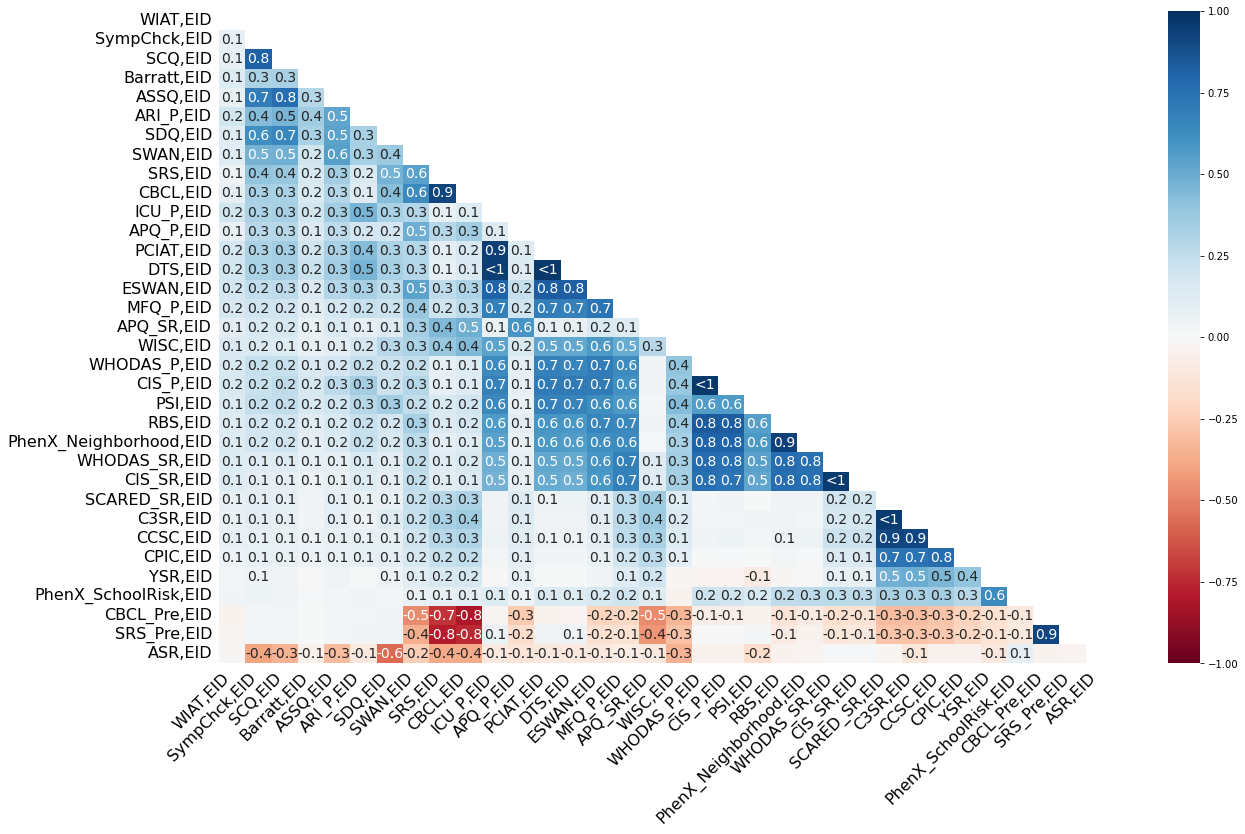

In [76]:
# Check if missingness of assessments is correlated

import missingno as msno
msno.heatmap(full_wo_underscore[relevant_EID_list])

import matplotlib.pyplot as plt
plt.savefig(data_output_dir + 'msno-heatmap.png')

In [77]:
missing_df = full_wo_underscore[relevant_EID_list].iloc[:, [i for i, n in enumerate(np.var(full_wo_underscore[relevant_EID_list].isnull(), axis='rows')) if n > 0]]
corr_mat = missing_df.isnull().corr()

In [78]:
corr_mat_flat = pd.melt(corr_mat.reset_index(), id_vars=['index'], value_vars=[x for x in corr_mat.columns if x!= "index"])
corr_mat_flat[(corr_mat_flat["value"] != 1) & (abs(corr_mat_flat["value"]) > 0.7)].sort_values(by="index")

# ==> 
# Strong (>0.7) positive and negative correlations:
#
# ASSQ (parents of all participants): ~ SympChck (parents of all participants), SCQ (parents of all participants)
# C3SRQ (>8yo): ~ >8yo
# CBCL: !~ CBCL_Pre, !~ SRS_Pre, ~SRS
# CBCL_Pre: ~ SRS_Pre, !~ CBCL, !~ SRS
# CCSC (>8yo): ~ >8yo
# CIS_P (parents of all participants): ~WHODAS_SR (all participants), PhenX_Neighborhood (parents of all participants), PCIAT (parents of all participants), RBS (parents of all participants), WHODAS_P (parents of all participants), DTS (parents of all participants), ESWAN (parents of all participants)
# CPIC (>8yo): ~ >8yo
# DTS (parents of all participants): ~ parents of all participants
# ESWAN (parents of all participants): ~ parents of all participants
# ICU_P (parents of all participants): ~ parents of all participants
# MFQ_P (parents of all participants): ~ parents of all participants
# PCIAT (parents of all participants): ~ parents of all participants
# PhenX_Neighborhood (parents of all participants): ~ parents of all participants, WHODAS_SR (all participants)
# RBS (parents of all participants): ~ parents of all participants, WHODAS_SR (all participants)
# SCARED_SR (>8yo): ~ >8yo
# SCQ: ~ ASSQ (parents of all participants), SympChck (parents of all participants)
# SRS: ~ CBCL, !~ CBCL_Pre, SRS_Pre
# SRS_Pre: !~ CBCL, SRS, ~CBCL_Pre
# SympChck (parents of all participants): ~ ASSQ (parents of all participants), SCQ (parents of all participants)
# WHODAS_P (parents of all participants): ~ WHODAS_SR (all participants),  ~ parents of all participants (PhenX_Neighborhood, RBS, CIS_P)
# WHODAS_SR (all participants): ~ parents of all participants (WHODAS_P, PhenX_Neighborhood, RBS, CIS_P)

,index,variable,value
38,"ASSQ,EID","SympChck,EID",0.701047
72,"ASSQ,EID","SCQ,EID",0.765077
944,"C3SR,EID","CCSC,EID",0.908387
876,"C3SR,EID","SCARED_SR,EID",0.960576
978,"C3SR,EID","CPIC,EID",0.738944
1063,"CBCL,EID","CBCL_Pre,EID",-0.811272
281,"CBCL,EID","SRS,EID",0.919213
1097,"CBCL,EID","SRS_Pre,EID",-0.749963
337,"CBCL_Pre,EID","CBCL,EID",-0.811272
1119,"CBCL_Pre,EID","SRS_Pre,EID",0.920268


In [79]:
# Check if missing columns are dependent on demographics

age_sex_cols = ["Basic_Demos,Age", "Basic_Demos,Sex"]
data_for_na_report = full_wo_underscore.copy()
data_for_na_report[relevant_EID_list] = data_for_na_report[relevant_EID_list].notnull().astype('int')

data_for_na_report[age_sex_cols] = data_for_na_report[age_sex_cols].astype('float')

corr_matrix = data_for_na_report[relevant_EID_list + age_sex_cols].corr().drop(labels=age_sex_cols)
corr_matrix_styled = corr_matrix[age_sex_cols].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)

import dataframe_image as dfi
dfi.export(corr_matrix_styled, data_output_dir + 'missingness-demos-corr.png')

corr_matrix[age_sex_cols].to_csv(data_output_dir + 'missingness-demos-corr.csv')

corr_matrix_styled

# ==> Strong (>0.7 only YSR, ages 11-17), no sex corr > abs(0.5)

[0809/125727.761783:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmpsocdlcq5/temp.png.
[0809/125728.932123:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmplaw8aeg8/temp.png.


,"Basic_Demos,Age","Basic_Demos,Sex"
"Basic_Demos,EID",nan,nan
"WIAT,EID",-0.00,-0.02
"SympChck,EID",-0.20,-0.02
"SCQ,EID",-0.19,-0.02
"Barratt,EID",-0.06,0.02
"ASSQ,EID",-0.16,-0.02
"ARI_P,EID",-0.08,-0.01
"SDQ,EID",-0.29,-0.03
"SWAN,EID",0.02,-0.02
"SRS,EID",0.03,-0.01


In [80]:
# Check if missing columns are dependent on barratt

barratt_cols = ["Barratt,Barratt_P1_Edu", "Barratt,Barratt_P1_Occ", "Barratt,Barratt_P2_Edu", "Barratt,Barratt_P2_Occ", "Barratt,Barratt_Total", "Barratt,Barratt_Total_Edu", "Barratt,Barratt_Total_Occ"]
data_for_na_report[barratt_cols] = data_for_na_report[barratt_cols].astype('float')
corr_matrix = data_for_na_report[relevant_EID_list + barratt_cols].corr().drop(labels=barratt_cols)
corr_matrix_styled = corr_matrix[barratt_cols].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)

import dataframe_image as dfi
dfi.export(corr_matrix_styled, data_output_dir + 'missingness-barratt-corr.png')

corr_matrix[barratt_cols].to_csv(data_output_dir + 'missingness-barratt-corr.csv')

corr_matrix_styled

# ==> No strong correlation

[0809/125731.384274:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmpb4nfmfsl/temp.png.
[0809/125732.819188:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmpfdxfzt78/temp.png.


,"Barratt,Barratt_P1_Edu","Barratt,Barratt_P1_Occ","Barratt,Barratt_P2_Edu","Barratt,Barratt_P2_Occ","Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ"
"Basic_Demos,EID",nan,nan,nan,nan,nan,nan,nan
"WIAT,EID",0.01,-0.01,0.01,-0.03,0.00,0.03,-0.00
"SympChck,EID",0.07,0.03,0.02,0.03,0.05,0.07,0.04
"SCQ,EID",0.07,0.03,0.02,0.04,0.06,0.08,0.05
"Barratt,EID",nan,nan,nan,nan,nan,nan,nan
"ASSQ,EID",0.08,0.04,0.03,0.03,0.05,0.08,0.04
"ARI_P,EID",0.08,0.03,0.09,0.07,0.10,0.09,0.09
"SDQ,EID",0.06,0.01,-0.01,0.02,0.04,0.06,0.03
"SWAN,EID",0.05,0.05,0.05,0.01,0.04,0.07,0.03
"SRS,EID",0.03,0.04,0.01,0.02,0.02,0.03,0.02


In [81]:
# Diagnosis counts (any position)
diag_distrib = data_up_to_SCARED[["Diag: " +x for x in diags]].sum().sort_values(ascending=False)
display(diag_distrib)

diag_distrib.to_csv("data/output/diag_distrib.csv")

Diag: ADHD-Inattentive Type                                                          583
Diag: ADHD-Combined Type                                                             551
Diag: Specific Learning Disorder with Impairment in Reading                          407
Diag: Generalized Anxiety Disorder                                                   314
Diag: Oppositional Defiant Disorder                                                  291
Diag: Autism Spectrum Disorder                                                       272
Diag: Language Disorder                                                              234
Diag: Social Anxiety (Social Phobia)                                                 218
Diag: Specific Phobia                                                                208
Diag: Specific Learning Disorder with Impairment in Mathematics                      187
Diag: Enuresis                                                                       183
Diag: Specific Learni